# ENCODE Long Read Sequel2 dataset

This tutorial guides through a typical Long Read Transcriptome Sequencing (LRTS) analysis workflow with isotools, 
using ENCODE Isoseq Sequel2 Data. It demonstrates the analysis of alternative splicing events within and between sample groups. 

## Preparation
Select the "long read RNA-seq" samples in the ENCODE data portal (https://www.encodeproject.org/) and download aligned .bam files. Here I use all Sequel II samples available at the time of writing, but you choose to process a subset.
Download the files with curl and use samtools to index the bam files.
``` sh
xargs -L 1 curl -O -J -L < ENCODE_files.txt
for bam in *bam; 
    do samtools index $bam
done
```
In addition to the bamfiles, a file metadata.tsv should have been downloaded, which we use to read the sample information. Further you need a reference annotation and a genome fastq file. Please see the Alzheimer tutorial how to get these files. 

## Data import

In [54]:

from  isotools import Transcriptome
from isotools import __version__ as isotools_version
print(f'This is isootools version {isotools_version}')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import logging
from collections import Counter

logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.INFO)
logger=logging.getLogger('isotools')


This is isootools version 0.1.4rc1


In [55]:
#I assume the encode data (e.g. the bam files) are in an subdirctory "encode"

#first, process the metadata
metadata_link="https://www.encodeproject.org/metadata/?type=Experiment&assay_title=long+read+RNA-seq&replicates.library.biosample.donor.organism.scientific_name=Homo+sapiens&files.file_type=bam&files.file_type=fastq&advancedQuery=date_released%3A%5B2009-02-01+TO+2021-12-31%5D&searchTerm=long+read+RNA-seq"
metadata=pd.read_csv(metadata_link, sep='\t')
platform=metadata.set_index('Experiment accession').Platform.dropna().to_dict()
for pf,count in Counter(platform.values()).items():
    print(f'{pf}: {count} samples from ENCODE')

#Select the samples from the metadata, make sure there are only bam files are in the table
samples=metadata[(metadata['Output type']=='alignments') & (metadata['File Status']=='released')].copy()
samples['Platform']=[platform.get(ea,'unknown') for ea in samples['Experiment accession']] #This info is missing for some files
samples=samples[['File accession','Output type','Biosample term name','Biosample type','Technical replicate(s)','Platform']].reset_index(drop=True) 
#we select all all SequelII files - adjust this as needed
samples=samples[samples.Platform=='Pacific Biosciences Sequel II'].reset_index(drop=True) 

#additional infos about the samples
infos=pd.read_csv('encode_samples.tsv', sep='\t').set_index('sample term')


chrom=[f'chr{i+1}'for i in range(22)]+['chrX','chrY']
#ENCODE uses an interesting reference, including sequences from viruses
genome='reference/GRCh38.p13.genome.fa'
anno='reference/gencode.v36.chr_patch_hapl_scaff.annotation_sorted'

#check that all selected files have been downloaded and indexed, and that they can be found in the right folder
notfound=[]
for accession in samples['File accession']:
    if not os.path.isfile(f"encode/{accession}.bam"):
        logger.warning(f'bam file not found for {accession}')
    elif not os.path.isfile(f"encode/{accession}.bam"):
        logger.warning(f'bam index not found for {accession}')
    else:
        continue
    notfound.append(accession)
        
#print the sample table
samples

Pacific Biosciences Sequel II: 51 samples from ENCODE
Pacific Biosciences Sequel: 16 samples from ENCODE
Oxford Nanopore MinION: 5 samples from ENCODE


File accession Output type                    Biosample term name  \
0     ENCFF319JFG  alignments                      neural crest cell   
1     ENCFF901XCR  alignments                      neural crest cell   
2     ENCFF344KQF  alignments                    left cardiac atrium   
3     ENCFF810FRP  alignments                                  HL-60   
4     ENCFF600MGT  alignments                                  HL-60   
5     ENCFF875QHC  alignments                   right cardiac atrium   
6     ENCFF698UNA  alignments                           psoas muscle   
7     ENCFF886FZQ  alignments                             left colon   
8     ENCFF449MVA  alignments               upper lobe of right lung   
9     ENCFF305AFY  alignments                  heart right ventricle   
10    ENCFF239CWJ  alignments                                 kidney   
11    ENCFF623IBV  alignments                   heart left ventricle   
12    ENCFF767KXS  alignments               lower lobe of right lung   
13    ENCFF626QRV  alignments                         cardiac septum   
14    ENCFF099TJN  alignments                                  aorta   
15    ENCFF779VVX  alignments                lower lobe of left lung   
16    ENCFF291EKY  alignments                   right cardiac atrium   
17    ENCFF850YMO  alignments     left ventricle myocardium superior   
18    ENCFF193WEX  alignments                           psoas muscle   
19    ENCFF925MYC  alignments                              osteocyte   
20    ENCFF558QPF  alignments                              osteocyte   
21    ENCFF973OML  alignments                 type B pancreatic cell   
22    ENCFF058HQU  alignments                 type B pancreatic cell   
23    ENCFF502LAB  alignments                   heart left ventricle   
24    ENCFF745DHX  alignments                                  Panc1   
25    ENCFF936VUF  alignments                        endodermal cell   
26    ENCFF939EUU  alignments                        endodermal cell   
27    ENCFF173JOL  alignments    Right ventricle myocardium inferior   
28    ENCFF132YCF  alignments     left ventricle myocardium inferior   
29    ENCFF509GHY  alignments  progenitor cell of endocrine pancreas   
30    ENCFF803KIA  alignments  progenitor cell of endocrine pancreas   
31    ENCFF971JDY  alignments                     mesenteric fat pad   
32    ENCFF745HHL  alignments                                  aorta   
33    ENCFF660UTF  alignments                  heart right ventricle   
34    ENCFF118JEI  alignments                                  MCF-7   
35    ENCFF044LIA  alignments                                   PC-3   
36    ENCFF322UJU  alignments                                   K562   
37    ENCFF400LRT  alignments                                 HCT116   
38    ENCFF814ABW  alignments                                  HepG2   
39    ENCFF018PZX  alignments                  heart right ventricle   
40    ENCFF219UJG  alignments                                GM12878   
41    ENCFF472TSL  alignments                    posterior vena cava   
42    ENCFF292UIE  alignments                                     H9   
43    ENCFF738RAA  alignments                                     H9   
44    ENCFF693YCD  alignments                    posterior vena cava   
45    ENCFF437SYY  alignments                   heart left ventricle   
46    ENCFF924HBV  alignments                lower lobe of left lung   
47    ENCFF545PJV  alignments                                 IMR-90   
48    ENCFF840OVC  alignments    Right ventricle myocardium superior   
49    ENCFF613SDS  alignments                   right cardiac atrium   
50    ENCFF984RMR  alignments                                  ovary   
51    ENCFF171AQO  alignments             mucosa of descending colon   
52    ENCFF648NAR  alignments                                GM12878   
53    ENCFF225CCJ  alignments                                GM12878   
54    ENCFF583MSU  alignments              

In [3]:
cols_of_interest=['cell', 'lineage', 'organ', 'karyotype']
try:    
    isoseq=Transcriptome(f'encode/encode_isotools.pkl')
except FileNotFoundError:
    try:
        isoseq=Transcriptome.from_reference(anno+'.isotools.pkl')
    except FileNotFoundError:
        isoseq=Transcriptome.from_reference(anno+'.gff3.gz')
        isoseq.save_reference(anno+'.isotools.pkl')
    for i,row in samples.iterrows():
        if row['File accession'] in notfound:
            continue
        sname=f"{row['Biosample term name']}_{row['Technical replicate(s)']}".replace(' ','_')
        if sname in isoseq.samples:
            l=ord('b')
            while f'{sname}_{l:c}' in isoseq.samples:
                l+=1
            sname=f'{sname}_{l:c}'
        cell_infos=infos.loc[row['Biosample term name'], cols_of_interest].to_dict()
        
        isoseq.add_sample_from_bam(f"encode/{row['File accession']}.bam", 
                                   use_satag=True,
                                   sample_name=sname , 
                                   group=row['Biosample term name'] ,
                                   sample_type=row['Biosample type'],
                                   platform=row['Platform'], **cell_infos) 
    isoseq.add_qc_metrics(genome) #3:41 min
    isoseq.make_index()
    isoseq.save('encode/encode_isotools.pkl')


INFO:loading transcriptome from encode/encode_isotoolsXXX.pkl
INFO:importing reference from pkl file reference/gencode.v36.chr_patch_hapl_scaff.annotation_sorted.isotools.pkl
INFO:adding sample heart_right_ventricle_1_1 from file encode/ENCFF660UTF.bam
100%|██████████| 1307404.0/1307404 [04:16<00:00, 5100.26reads/s, chr=ERCC-00171]              
INFO:imported 1989 chimeric alignments that can be chained to single nonchimeric transcripts (long intron alingment split)
INFO:ignoring 27805 chimeric alignments with less than 2 reads
INFO:imported 1253432 nonchimeric reads (including  1989 chained chimeric alignments) and 14813 chimeric reads with coverage of at least 2.
INFO:adding sample neural_crest_cell_1_1 from file encode/ENCFF319JFG.bam
100%|██████████| 873315.0/873315 [02:39<00:00, 5477.50reads/s, chr=ERCC-00171]             
INFO:imported 1345 chimeric alignments that can be chained to single nonchimeric transcripts (long intron alingment split)
INFO:ignoring 6274 chimeric alignment

## Quality control and filtering
First, we will depict some quality metrics and define filtering criteria. For more information on techical artefacts, quality metrics, and filtering, see the Alzheimer tutorial. 

In [40]:
from isotools import DEFAULT_GENE_FILTER, DEFAULT_TRANSCRIPT_FILTER,DEFAULT_REF_TRANSCRIPT_FILTER
#add gencode specific filters
ref_filter=DEFAULT_REF_TRANSCRIPT_FILTER
ref_filter['HIGH_SUPPORT']='transcript_support_level=="1"'
ref_filter['PROTEIN_CODING']='transcript_type=="protein_coding"'

isoseq.add_filter( gene_filter=gene_filter, ref_transcript_filter=ref_filter)


100%|██████████| 571113/571113 [00:37<00:00, 15260.20it/s]


In [5]:
#compute some summary statistics on technical artifacts. 
# For this analysis samples are grouped by 'Biosample term name'
tr_stats=[
    isoseq.transcript_length_hist(groups=isoseq.groups(), add_reference=True, min_coverage=2,tr_filter=dict( remove=['NOVEL_GENE']), ref_filter=dict(include=['HIGH_SUPPORT'])),
    isoseq.downstream_a_hist(groups=isoseq.groups(), tr_filter=dict( remove=['NOVEL_GENE', 'UNSPLICED']), ref_filter=dict(remove=['UNSPLICED'])),
    isoseq.downstream_a_hist(groups=isoseq.groups(), tr_filter=dict(include=['NOVEL_GENE', 'UNSPLICED'])),
    isoseq.direct_repeat_hist(groups=isoseq.groups(),bins=np.linspace(-.5,10.5,12))]

tr_stats.append((pd.concat([tr_stats[2][0].add_suffix(' novel unspliced'),tr_stats[1][0].add_suffix(' known multiexon')],axis=1),tr_stats[2][1]))

#statistic on the filter flags
f_stats=isoseq.filter_stats( groups=isoseq.groups(), weight_by_coverage=True,min_coverage=1)
f_stats[0].index=f_stats[0].index.str.replace('_','\n')

INFO:Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:NumExpr defaulting to 8 threads.


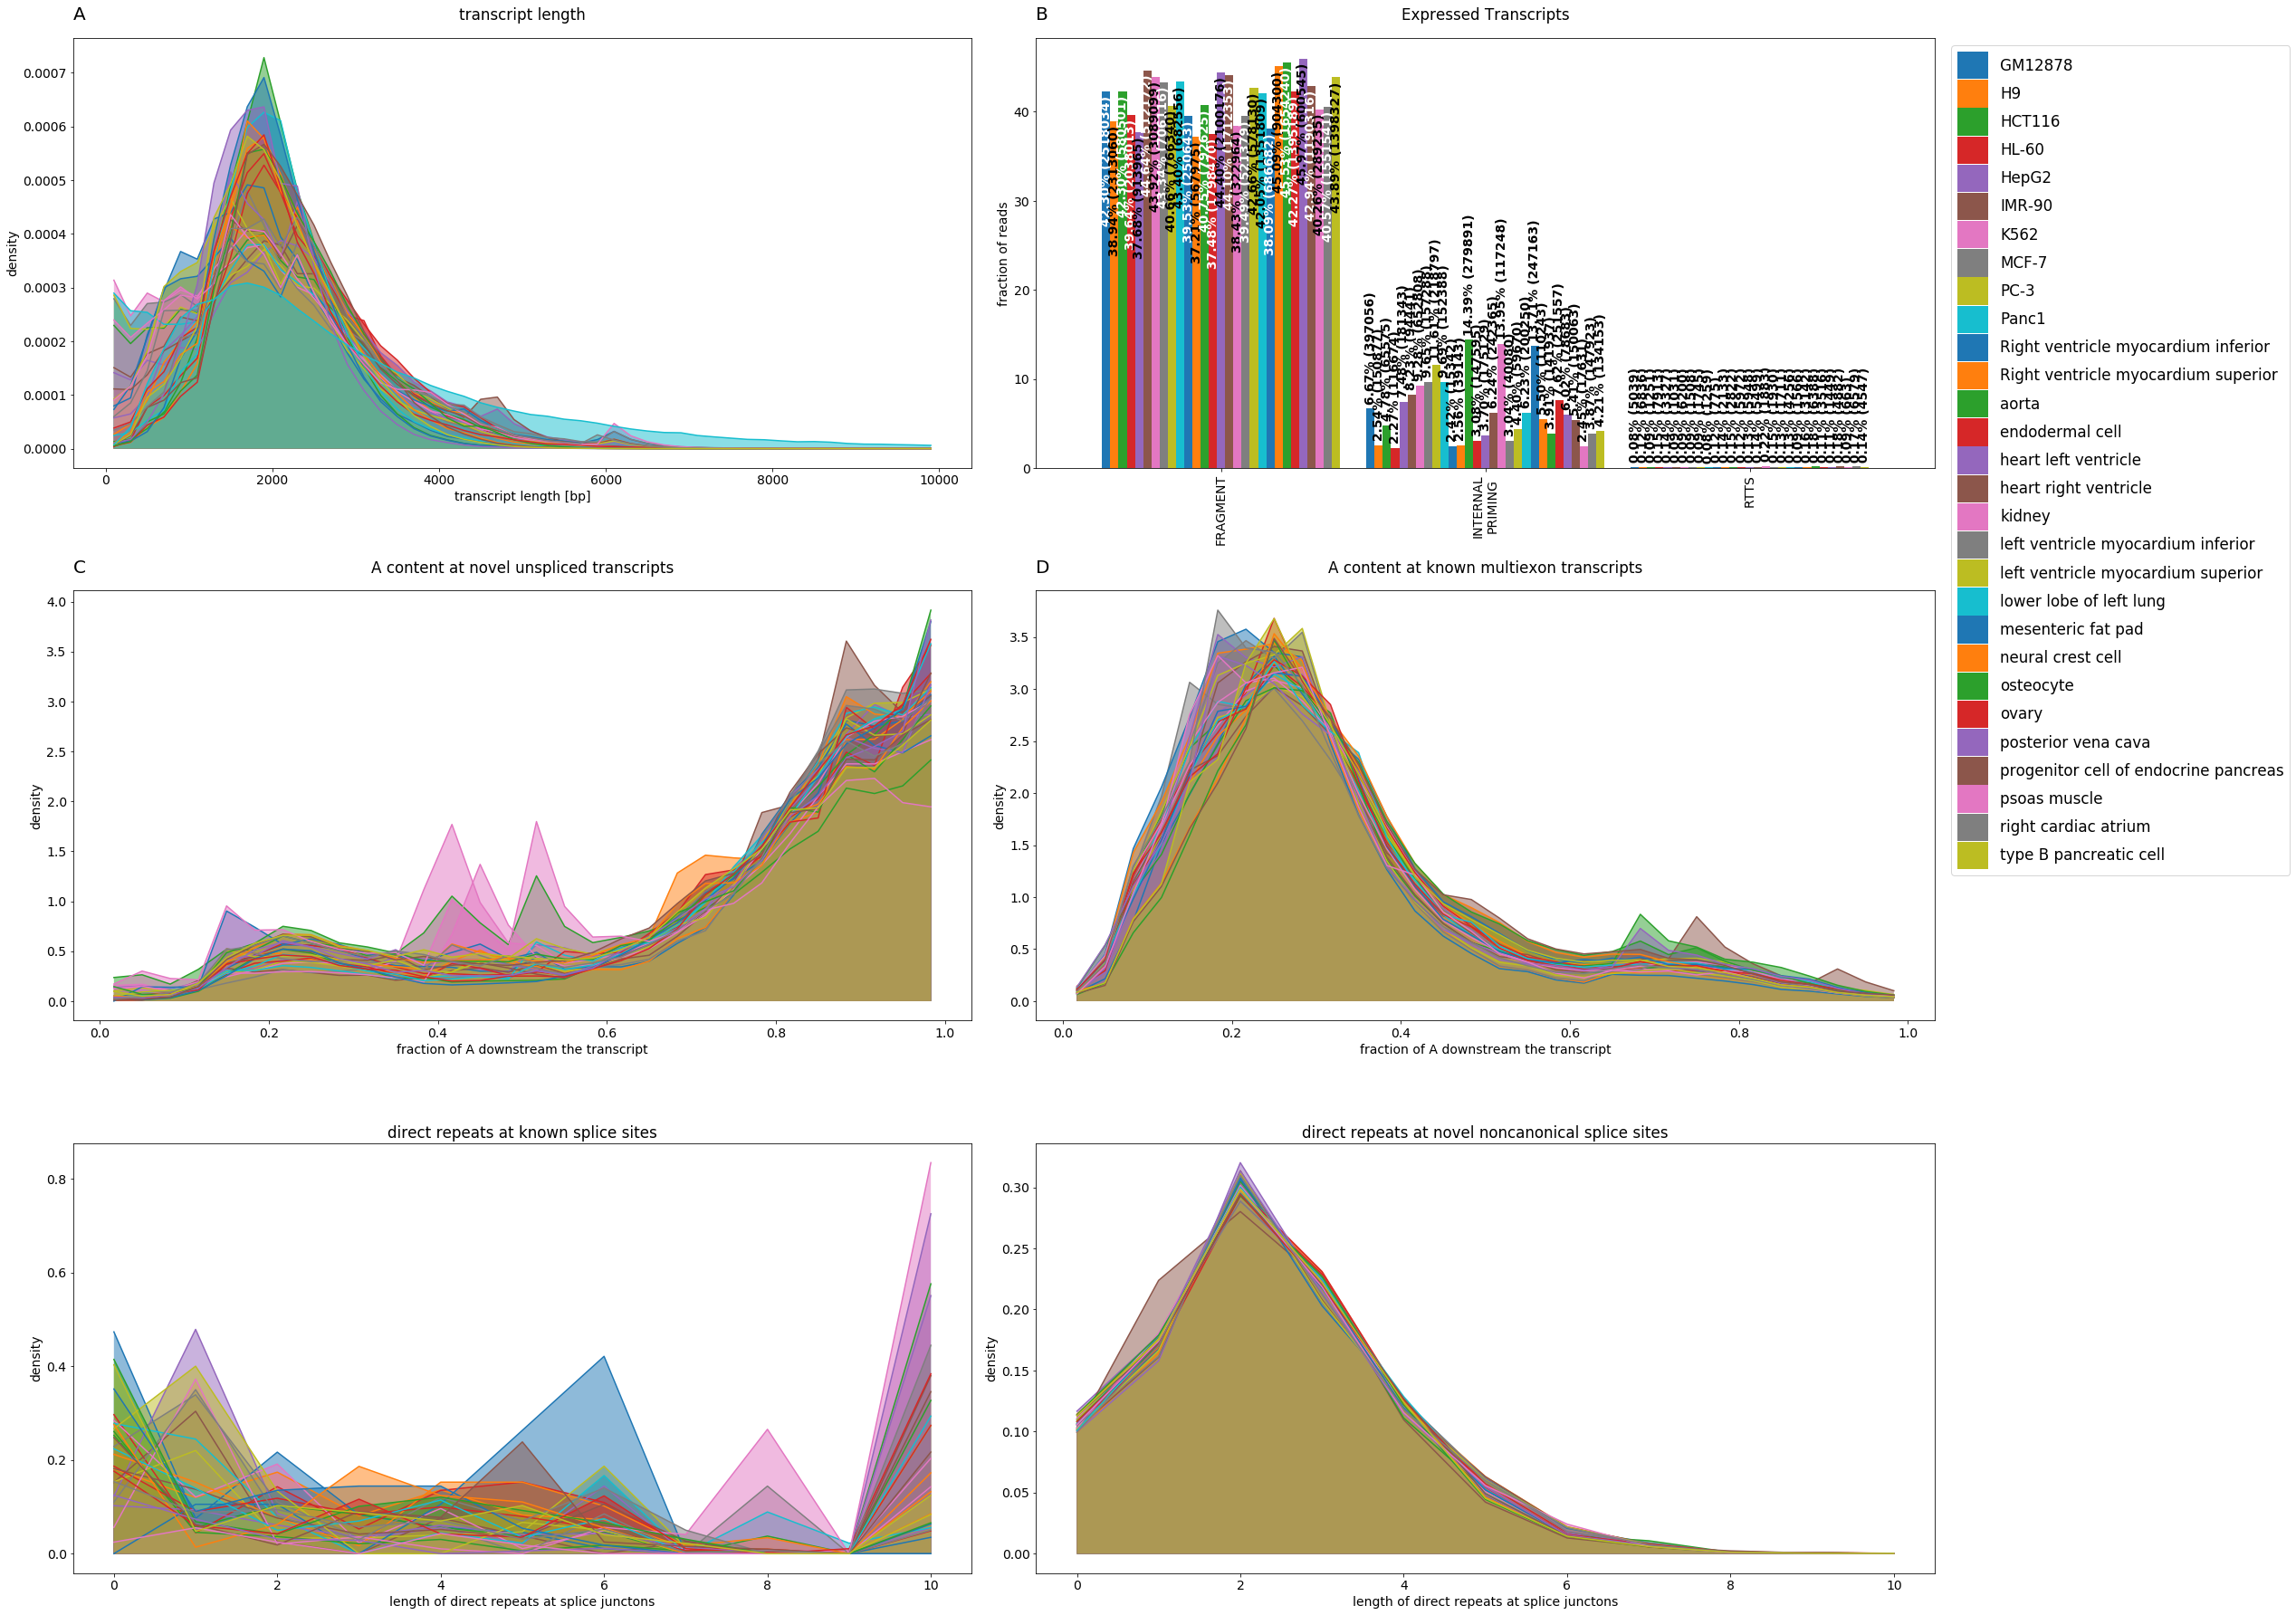

In [6]:
#QC plot
from isotools.plots import plot_bar, plot_distr

plt.rcParams["figure.figsize"] = (30,25)
plt.rcParams.update({'font.size': 14})

fig, axs = plt.subplots(3,2)
#A) transcript length
plot_distr(tr_stats[0][0],smooth=3,ax=axs[0,0],legend=False,**tr_stats[0][1])  
#D) frequency of artifacts
plot_bar(f_stats[0],ax=axs[0,1],drop_categories=['MULTIEXON','NOVEL\nTRANSCRIPT','NOVEL','UNSPLICED','NONCANONICAL\nSPLICING' ],bar_width=.9,legend=False,**f_stats[1])  
#B) internal priming
plot_distr(tr_stats[4][0][[c for c in tr_stats[4][0].columns if 'novel' in c]],smooth=3,ax=axs[1,0],legend=False,density=True,fill=True, title= 'A content at novel unspliced transcripts', xlabel='fraction of A downstream the transcript')  
plot_distr(tr_stats[4][0][[c for c in tr_stats[4][0].columns if 'known' in c]],smooth=3,ax=axs[1,1],legend=False,density=True,fill=True, title= 'A content at known multiexon transcripts', xlabel='fraction of A downstream the transcript')  
#C) RTTS
plot_distr(tr_stats[3][0][[c for c in tr_stats[3][0].columns if 'novel' in c]],ax=axs[2,0],legend=False,density=True,title='direct repeats at known splice sites',ylabel='density',xlabel= 'length of direct repeats at splice junctons')  
plot_distr(tr_stats[3][0][[c for c in tr_stats[3][0].columns if 'known' in c]],ax=axs[2,1],legend=False,density=True,title='direct repeats at novel noncanonical splice sites',ylabel='density',xlabel= 'length of direct repeats at splice junctons')  

for letter,ax in zip('ABCD',axs.flatten()):
    ax.set_title(letter,{'fontsize':20}, loc='left', pad=20)
fig.tight_layout()
axs[0,1].legend(fontsize='large', ncol=1,handleheight=2.4, labelspacing=0.05, bbox_to_anchor=(1.01, 1))


In [7]:
f_stats_sample=isoseq.filter_stats( weight_by_coverage=True,min_coverage=1)


Quality metrics vary substantially between the individual samples, in particular for internal priming artifacts. On the other hand, RRTS seems to be almost absent in this data, indicating that the alignments may have been filtered. The fractions of affected reads for the different artifacts can be depicted as a bar chart.

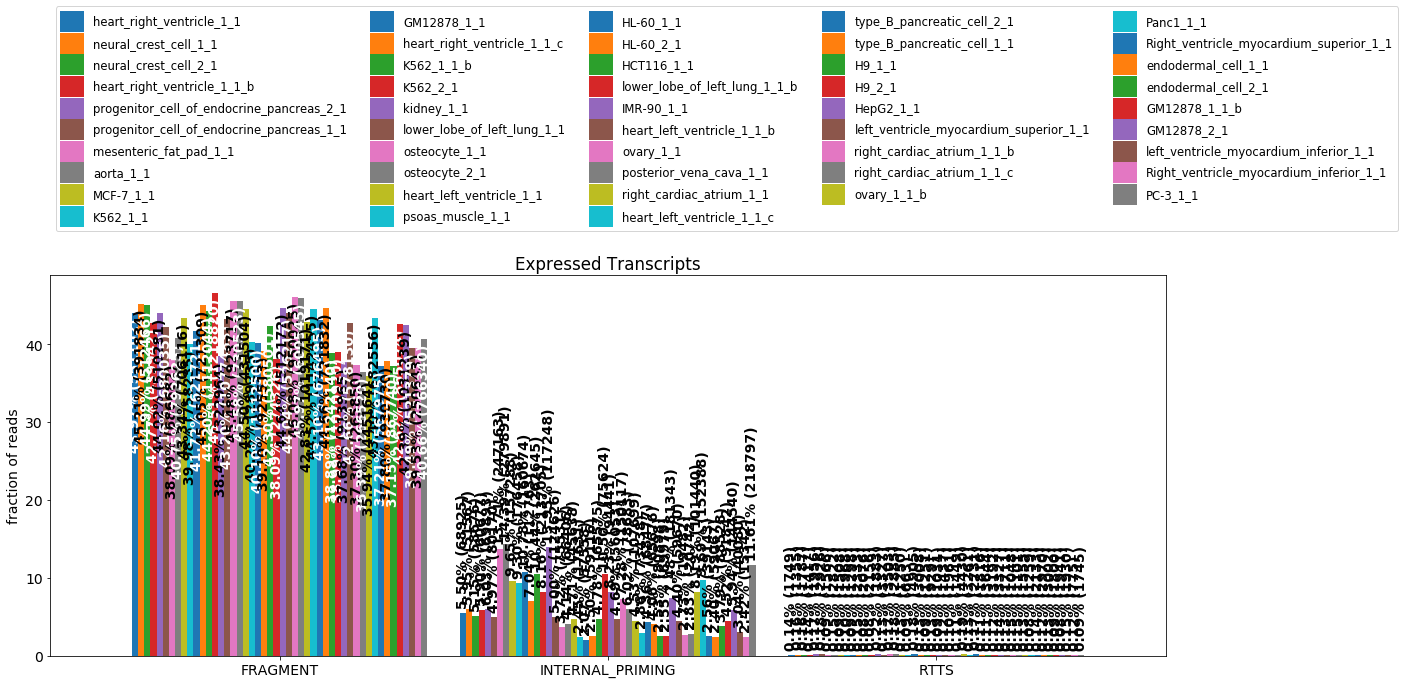

In [8]:
#plot technical artifacts for individual samples
plt.rcParams["figure.figsize"] = (20,7)
plot_bar(f_stats_sample[0],drop_categories=['MULTIEXON','NOVEL_TRANSCRIPT','NOVEL','UNSPLICED','NONCANONICAL_SPLICING' ],legend=False,rot=0, bar_width=.9,**f_stats_sample[1])  
plt.legend(fontsize='small', ncol=5,handleheight=2.4, labelspacing=0.05, bbox_to_anchor=(0, 1.1), loc='lower left')

## Data exploration
To explore the relation of the samples with respect to splicing we look at PCA and UMAP embeddings based on alternative splicing events.

In [9]:
#Compute alternative splicing events by finding "bubbles" in the segment graphs
splice_events=isoseq.alternative_splicing_events()

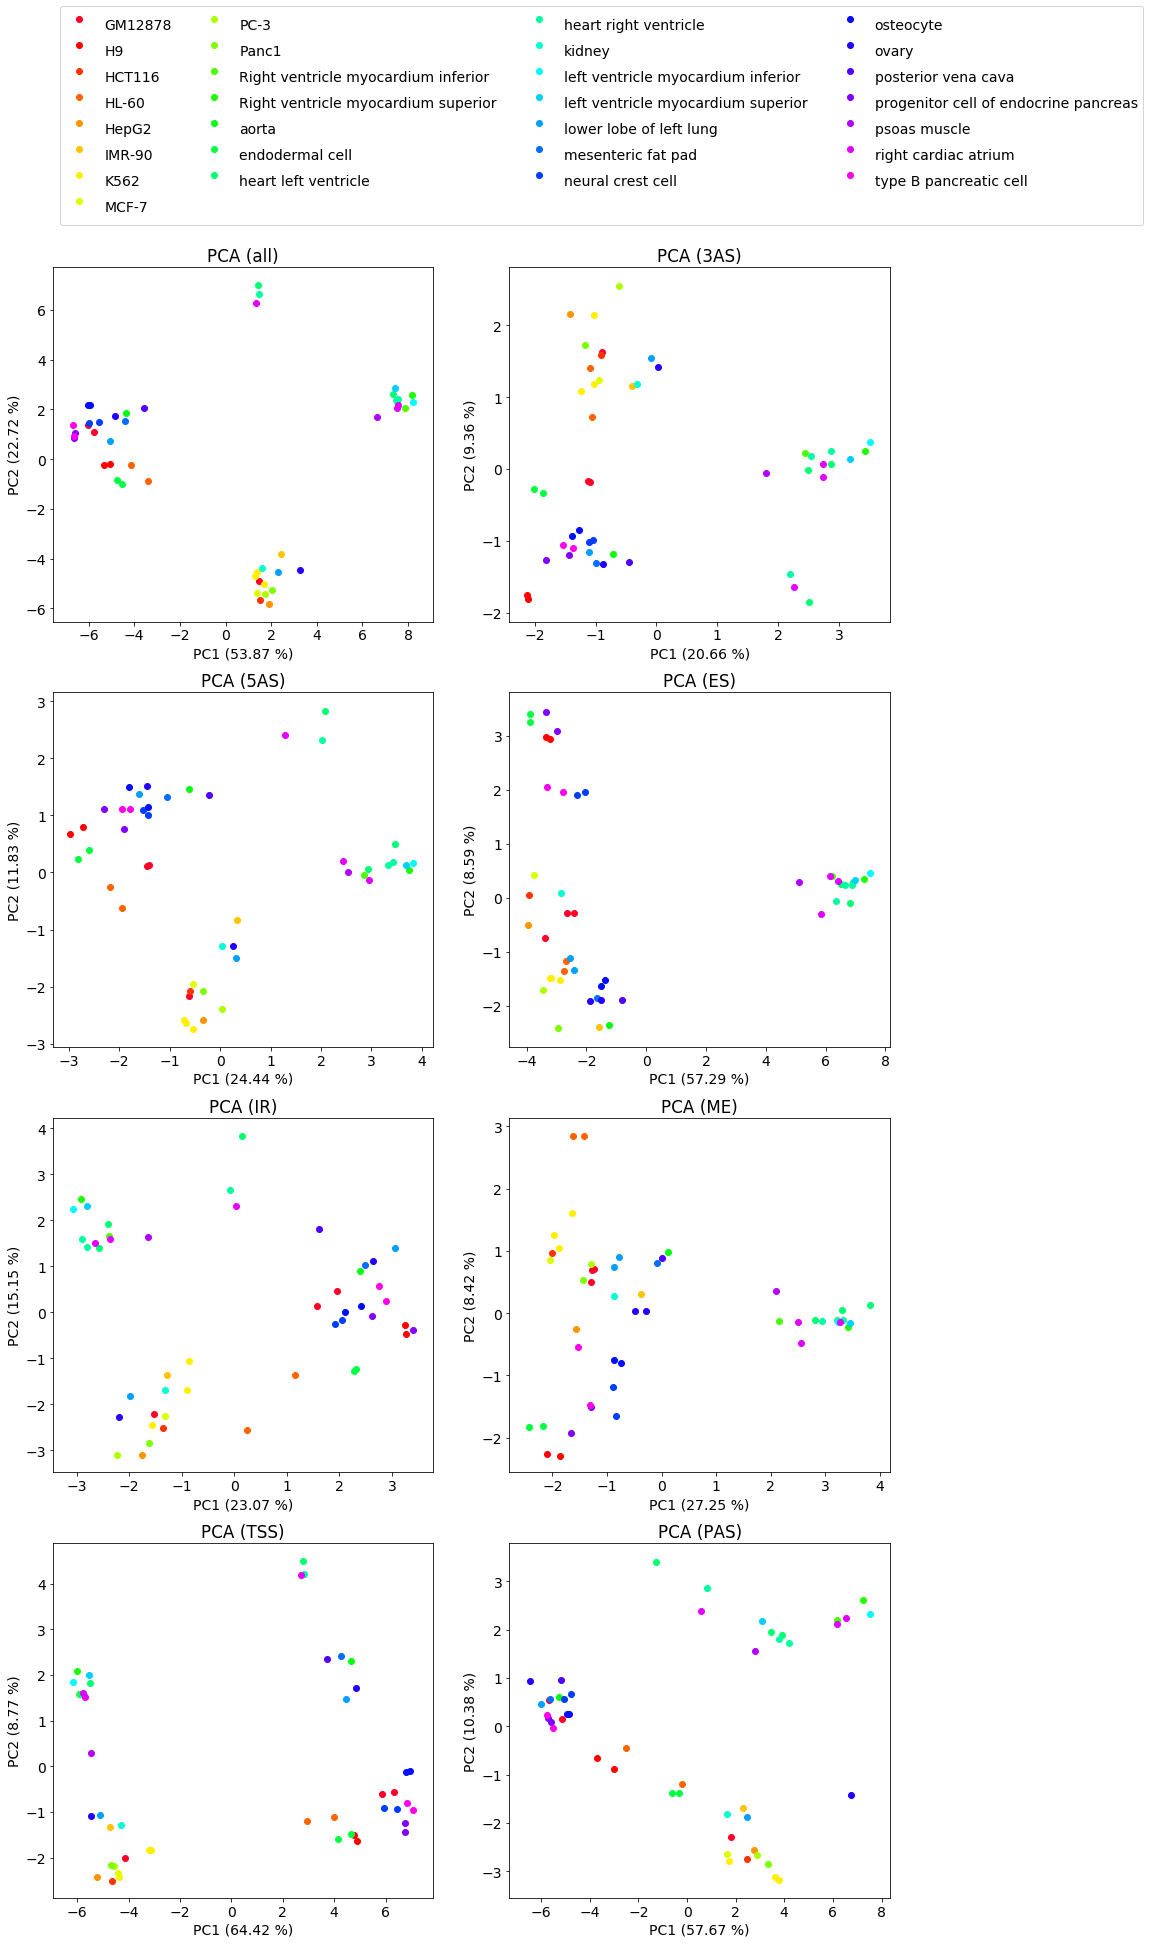

In [10]:
#plot PCA embedding
from isotools.plots import plot_embedding
plt.rcParams["figure.figsize"] = (15,30)

pca={}

f,axs=plt.subplots(4,2)
for ax,t in zip(axs.flatten(),['all','3AS','5AS','ES','IR','ME', 'TSS', 'PAS']):
    pca[t]=plot_embedding(splice_events, ax=ax, labels=False, groups=isoseq.groups(), splice_types=t)
    

axs[0,0].legend(fontsize='medium', ncol=4,handleheight=2.4, labelspacing=0.05, bbox_to_anchor=(0, 1.1), loc='lower left')
#plt.tight_layout()


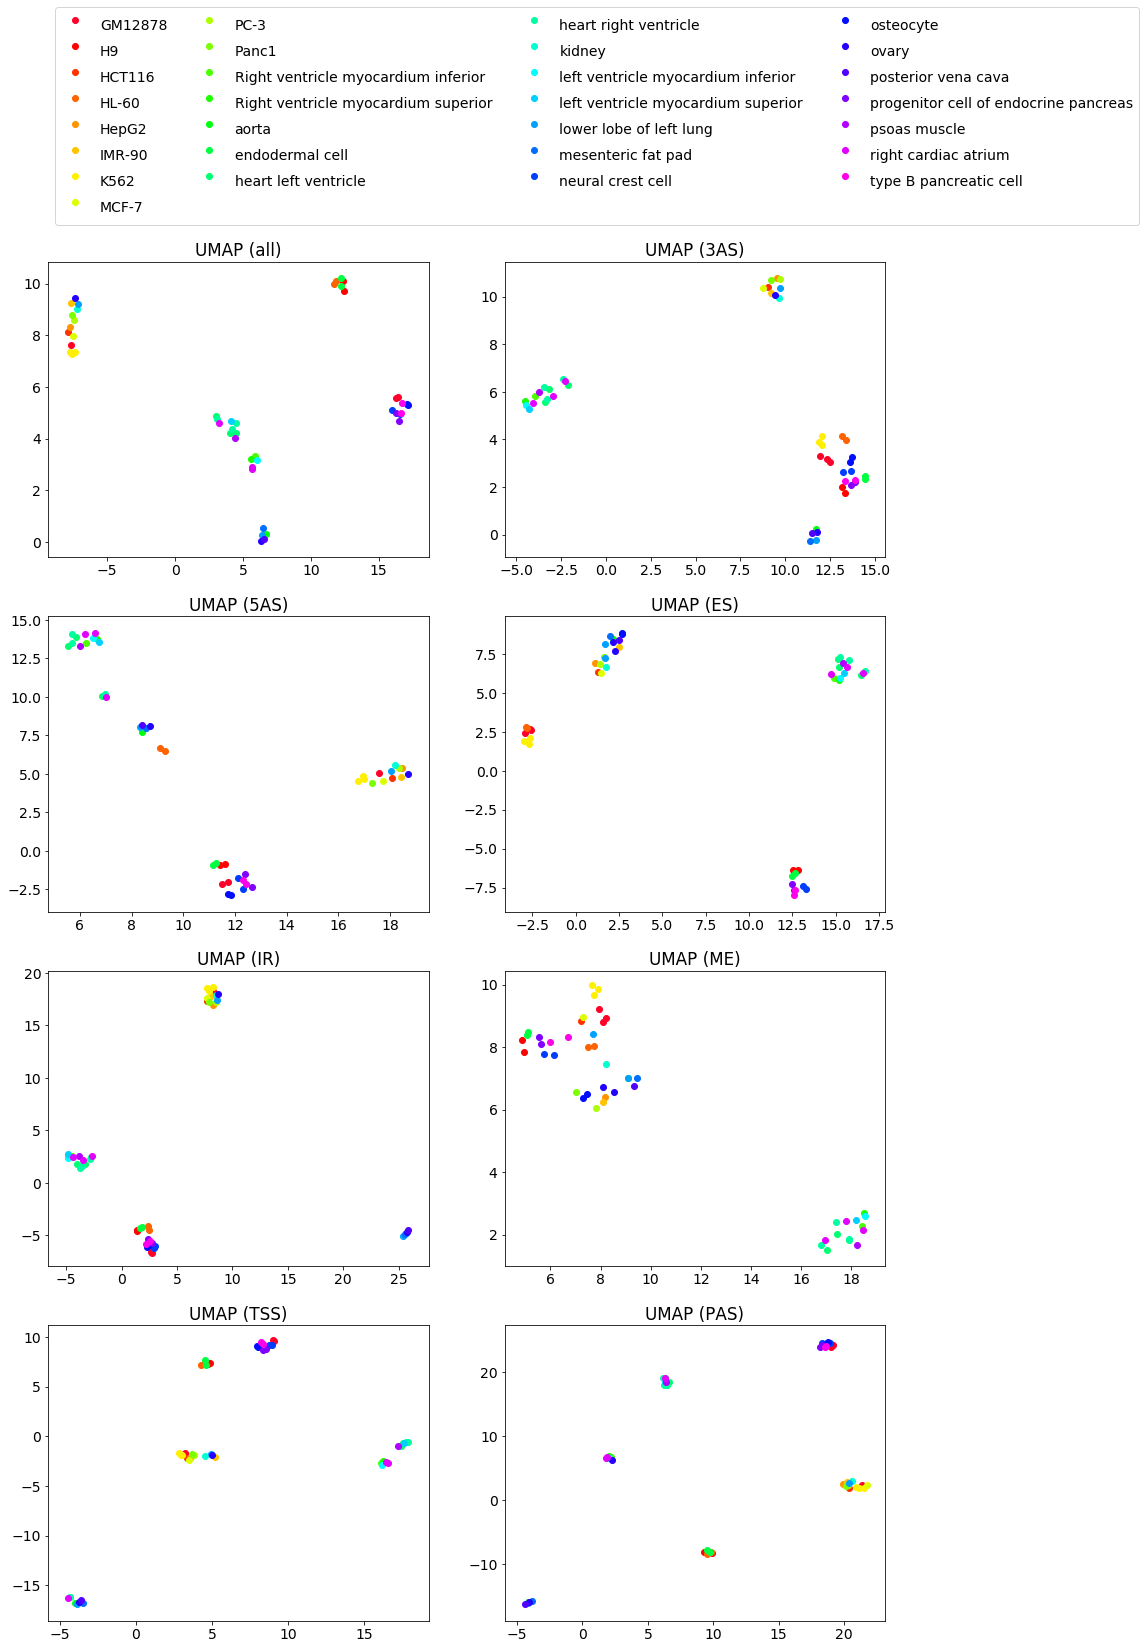

In [11]:
#plot UMAP embedding 
# the clustering of samples very much depends on the n_neighbors parameter
plt.rcParams["figure.figsize"] = (15,25)
umap={}
f,axs=plt.subplots(4,2)
for ax,t in zip(axs.flatten(),['all','3AS','5AS','ES','IR','ME', 'TSS', 'PAS']):
    umap[t]=plot_embedding(splice_events, method='UMAP',n_neighbors=6, ax=ax, labels=False, groups=isoseq.groups(), splice_types=t)
    

axs[0,0].legend(fontsize='medium', ncol=4,handleheight=2.4, labelspacing=0.05, bbox_to_anchor=(0, 1.1), loc='lower left')


INFO:restricting embedding on samples MCF-7_1_1, K562_1_1, K562_1_1_b, K562_2_1, HL-60_1_1, HL-60_2_1, HCT116_1_1, HepG2_1_1, Panc1_1_1, PC-3_1_1
INFO:restricting embedding on samples MCF-7_1_1, K562_1_1, K562_1_1_b, K562_2_1, HL-60_1_1, HL-60_2_1, HCT116_1_1, HepG2_1_1, Panc1_1_1, PC-3_1_1
INFO:restricting embedding on samples MCF-7_1_1, K562_1_1, K562_1_1_b, K562_2_1, HL-60_1_1, HL-60_2_1, HCT116_1_1, HepG2_1_1, Panc1_1_1, PC-3_1_1
INFO:restricting embedding on samples MCF-7_1_1, K562_1_1, K562_1_1_b, K562_2_1, HL-60_1_1, HL-60_2_1, HCT116_1_1, HepG2_1_1, Panc1_1_1, PC-3_1_1
INFO:restricting embedding on samples MCF-7_1_1, K562_1_1, K562_1_1_b, K562_2_1, HL-60_1_1, HL-60_2_1, HCT116_1_1, HepG2_1_1, Panc1_1_1, PC-3_1_1
INFO:restricting embedding on samples MCF-7_1_1, K562_1_1, K562_1_1_b, K562_2_1, HL-60_1_1, HL-60_2_1, HCT116_1_1, HepG2_1_1, Panc1_1_1, PC-3_1_1
INFO:restricting embedding on samples MCF-7_1_1, K562_1_1, K562_1_1_b, K562_2_1, HL-60_1_1, HL-60_2_1, HCT116_1_1, HepG2_1_1

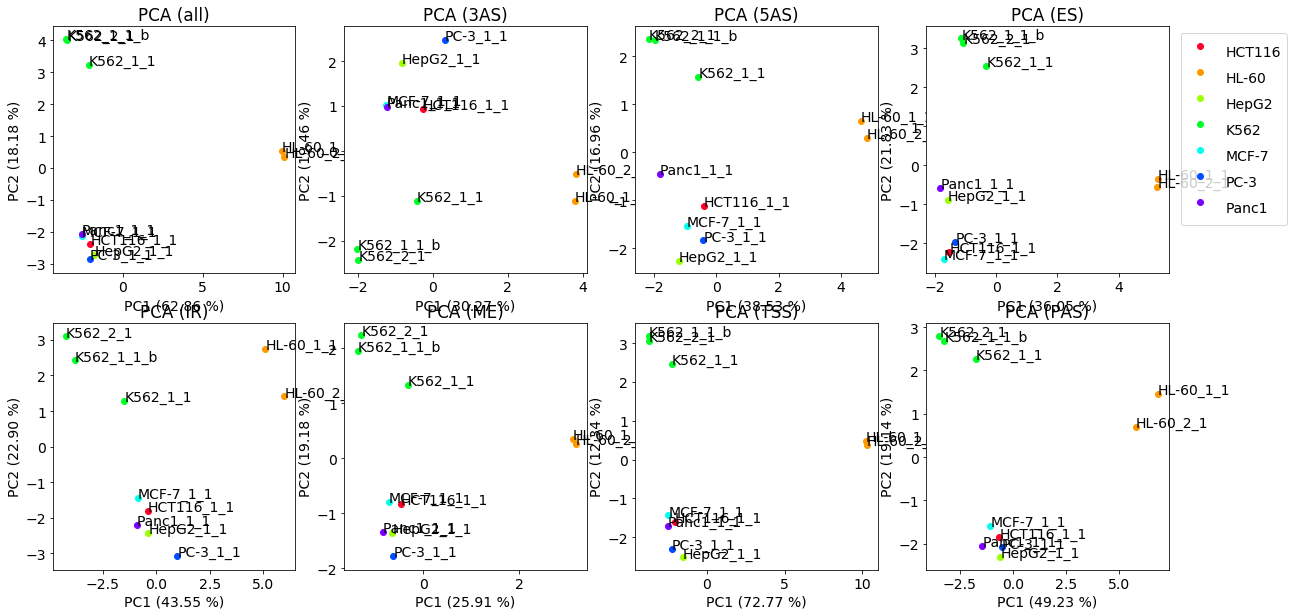

In [12]:
#plot PCA embedding of cancer cell lines only
#This seperates leukemia cell lines from carcinoma cell lines
from isotools.plots import plot_embedding
plt.rcParams["figure.figsize"] = (20,10)
lineage=isoseq.groups('lineage')
sample_type=isoseq.groups('sample_type')
karyotype=isoseq.groups('karyotype')
organ=isoseq.groups('organ')

groups=isoseq.groups()
groups={k:[sa for sa in v if sa in karyotype['cancer']] for k,v in groups.items()}
groups={k:v for k,v in groups.items() if v}
f,axs=plt.subplots(2,4)
for ax,t in zip(axs.flatten(),['all','3AS','5AS','ES','IR','ME', 'TSS', 'PAS']):
    _=plot_embedding(splice_events, ax=ax, labels=True, groups=groups, splice_types=t)
    

axs[0,3].legend(fontsize='medium', ncol=1,handleheight=2.4, labelspacing=0.05, bbox_to_anchor=(1.02, 1), loc='upper left')

INFO:restricting embedding on samples heart_right_ventricle_1_1, heart_right_ventricle_1_1_b, heart_right_ventricle_1_1_c, heart_left_ventricle_1_1, heart_left_ventricle_1_1_b, right_cardiac_atrium_1_1, heart_left_ventricle_1_1_c, left_ventricle_myocardium_superior_1_1, right_cardiac_atrium_1_1_b, right_cardiac_atrium_1_1_c, Right_ventricle_myocardium_superior_1_1, left_ventricle_myocardium_inferior_1_1, Right_ventricle_myocardium_inferior_1_1
INFO:restricting embedding on samples heart_right_ventricle_1_1, heart_right_ventricle_1_1_b, heart_right_ventricle_1_1_c, heart_left_ventricle_1_1, heart_left_ventricle_1_1_b, right_cardiac_atrium_1_1, heart_left_ventricle_1_1_c, left_ventricle_myocardium_superior_1_1, right_cardiac_atrium_1_1_b, right_cardiac_atrium_1_1_c, Right_ventricle_myocardium_superior_1_1, left_ventricle_myocardium_inferior_1_1, Right_ventricle_myocardium_inferior_1_1
INFO:restricting embedding on samples heart_right_ventricle_1_1, heart_right_ventricle_1_1_b, heart_righ

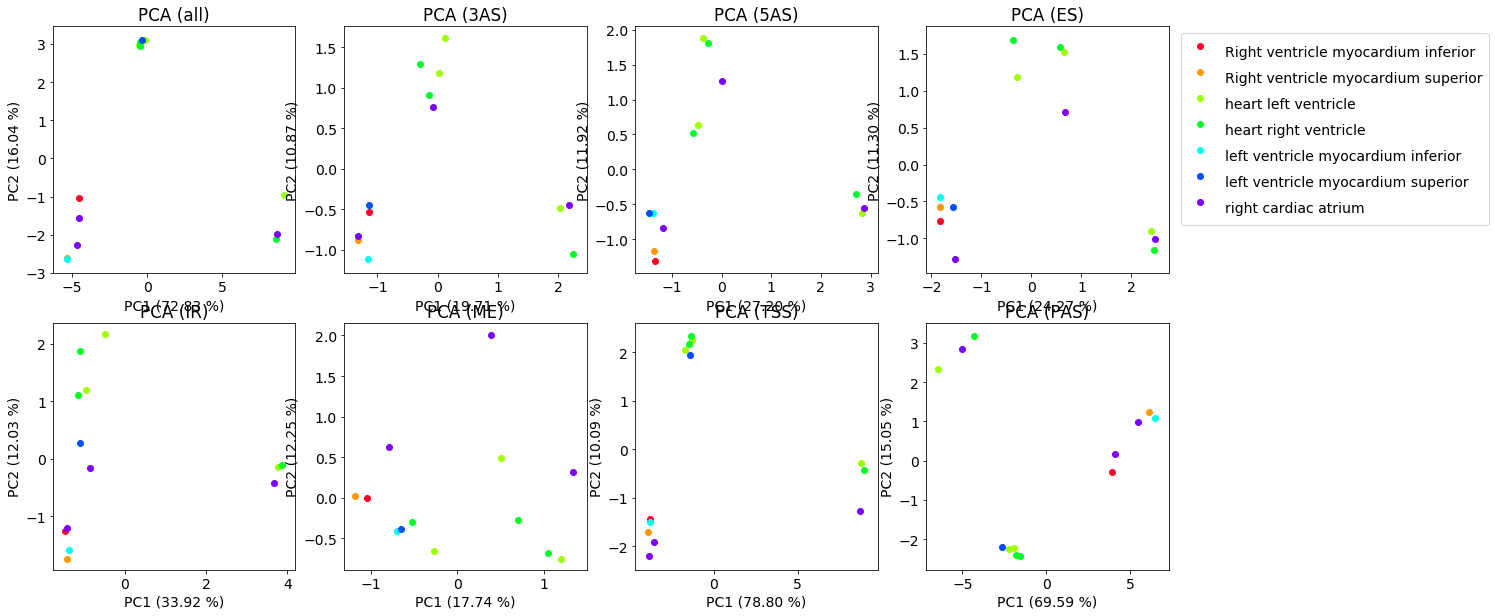

In [13]:
#plot PCA embedding of heart samples only
from isotools.plots import plot_embedding
plt.rcParams["figure.figsize"] = (20,10)
lineage=isoseq.groups('lineage')
sample_type=isoseq.groups('sample_type')
karyotype=isoseq.groups('karyotype')
organ=isoseq.groups('organ')

groups=isoseq.groups()
groups={k:[sa for sa in v if sa in organ['heart']] for k,v in groups.items()}
groups={k:v for k,v in groups.items() if v}
f,axs=plt.subplots(2,4)
for ax,t in zip(axs.flatten(),['all','3AS','5AS','ES','IR','ME', 'TSS', 'PAS']):
    _=plot_embedding(splice_events, ax=ax, labels=False, groups=groups, splice_types=t)
    

axs[0,3].legend(fontsize='medium', ncol=1,handleheight=2.4, labelspacing=0.05, bbox_to_anchor=(1.02, 1), loc='upper left')

## Novel alternative splicing classification

In [14]:

cname=['FSM','ISM','NIC','NNC','novel gene']
cnr={}
for g, trid, tr in isoseq.iter_transcripts():
    for anno in tr['annotation'][1]:
        cnr[anno]=min(cnr.get(anno,5),tr['annotation'][0])
del cnr['FSM']
altsplice=[ isoseq.altsplice_stats(groups=isoseq.groups(), weight_by_coverage=True, min_coverage=1, tr_filter=dict( remove=['RTTS', 'FRAGMENT', 'INTERNAL_PRIMING'])),
            isoseq.altsplice_stats(groups=isoseq.groups(), weight_by_coverage=True, min_coverage=2, tr_filter=dict( remove=['RTTS', 'FRAGMENT', 'INTERNAL_PRIMING'])),
            isoseq.altsplice_stats(groups=isoseq.groups(), weight_by_coverage=False, min_coverage=20, tr_filter=dict( remove=['RTTS', 'FRAGMENT', 'INTERNAL_PRIMING']))]
for i in range(3):
    altsplice[i][0].index=altsplice[i][0].index+[f'\n({cname[cnr[subcat]]})' if subcat in cnr else '' for subcat in altsplice[i][0].index]
    altsplice[i][0].index=altsplice[i][0].index.str.replace('splice ','\nsplice ')

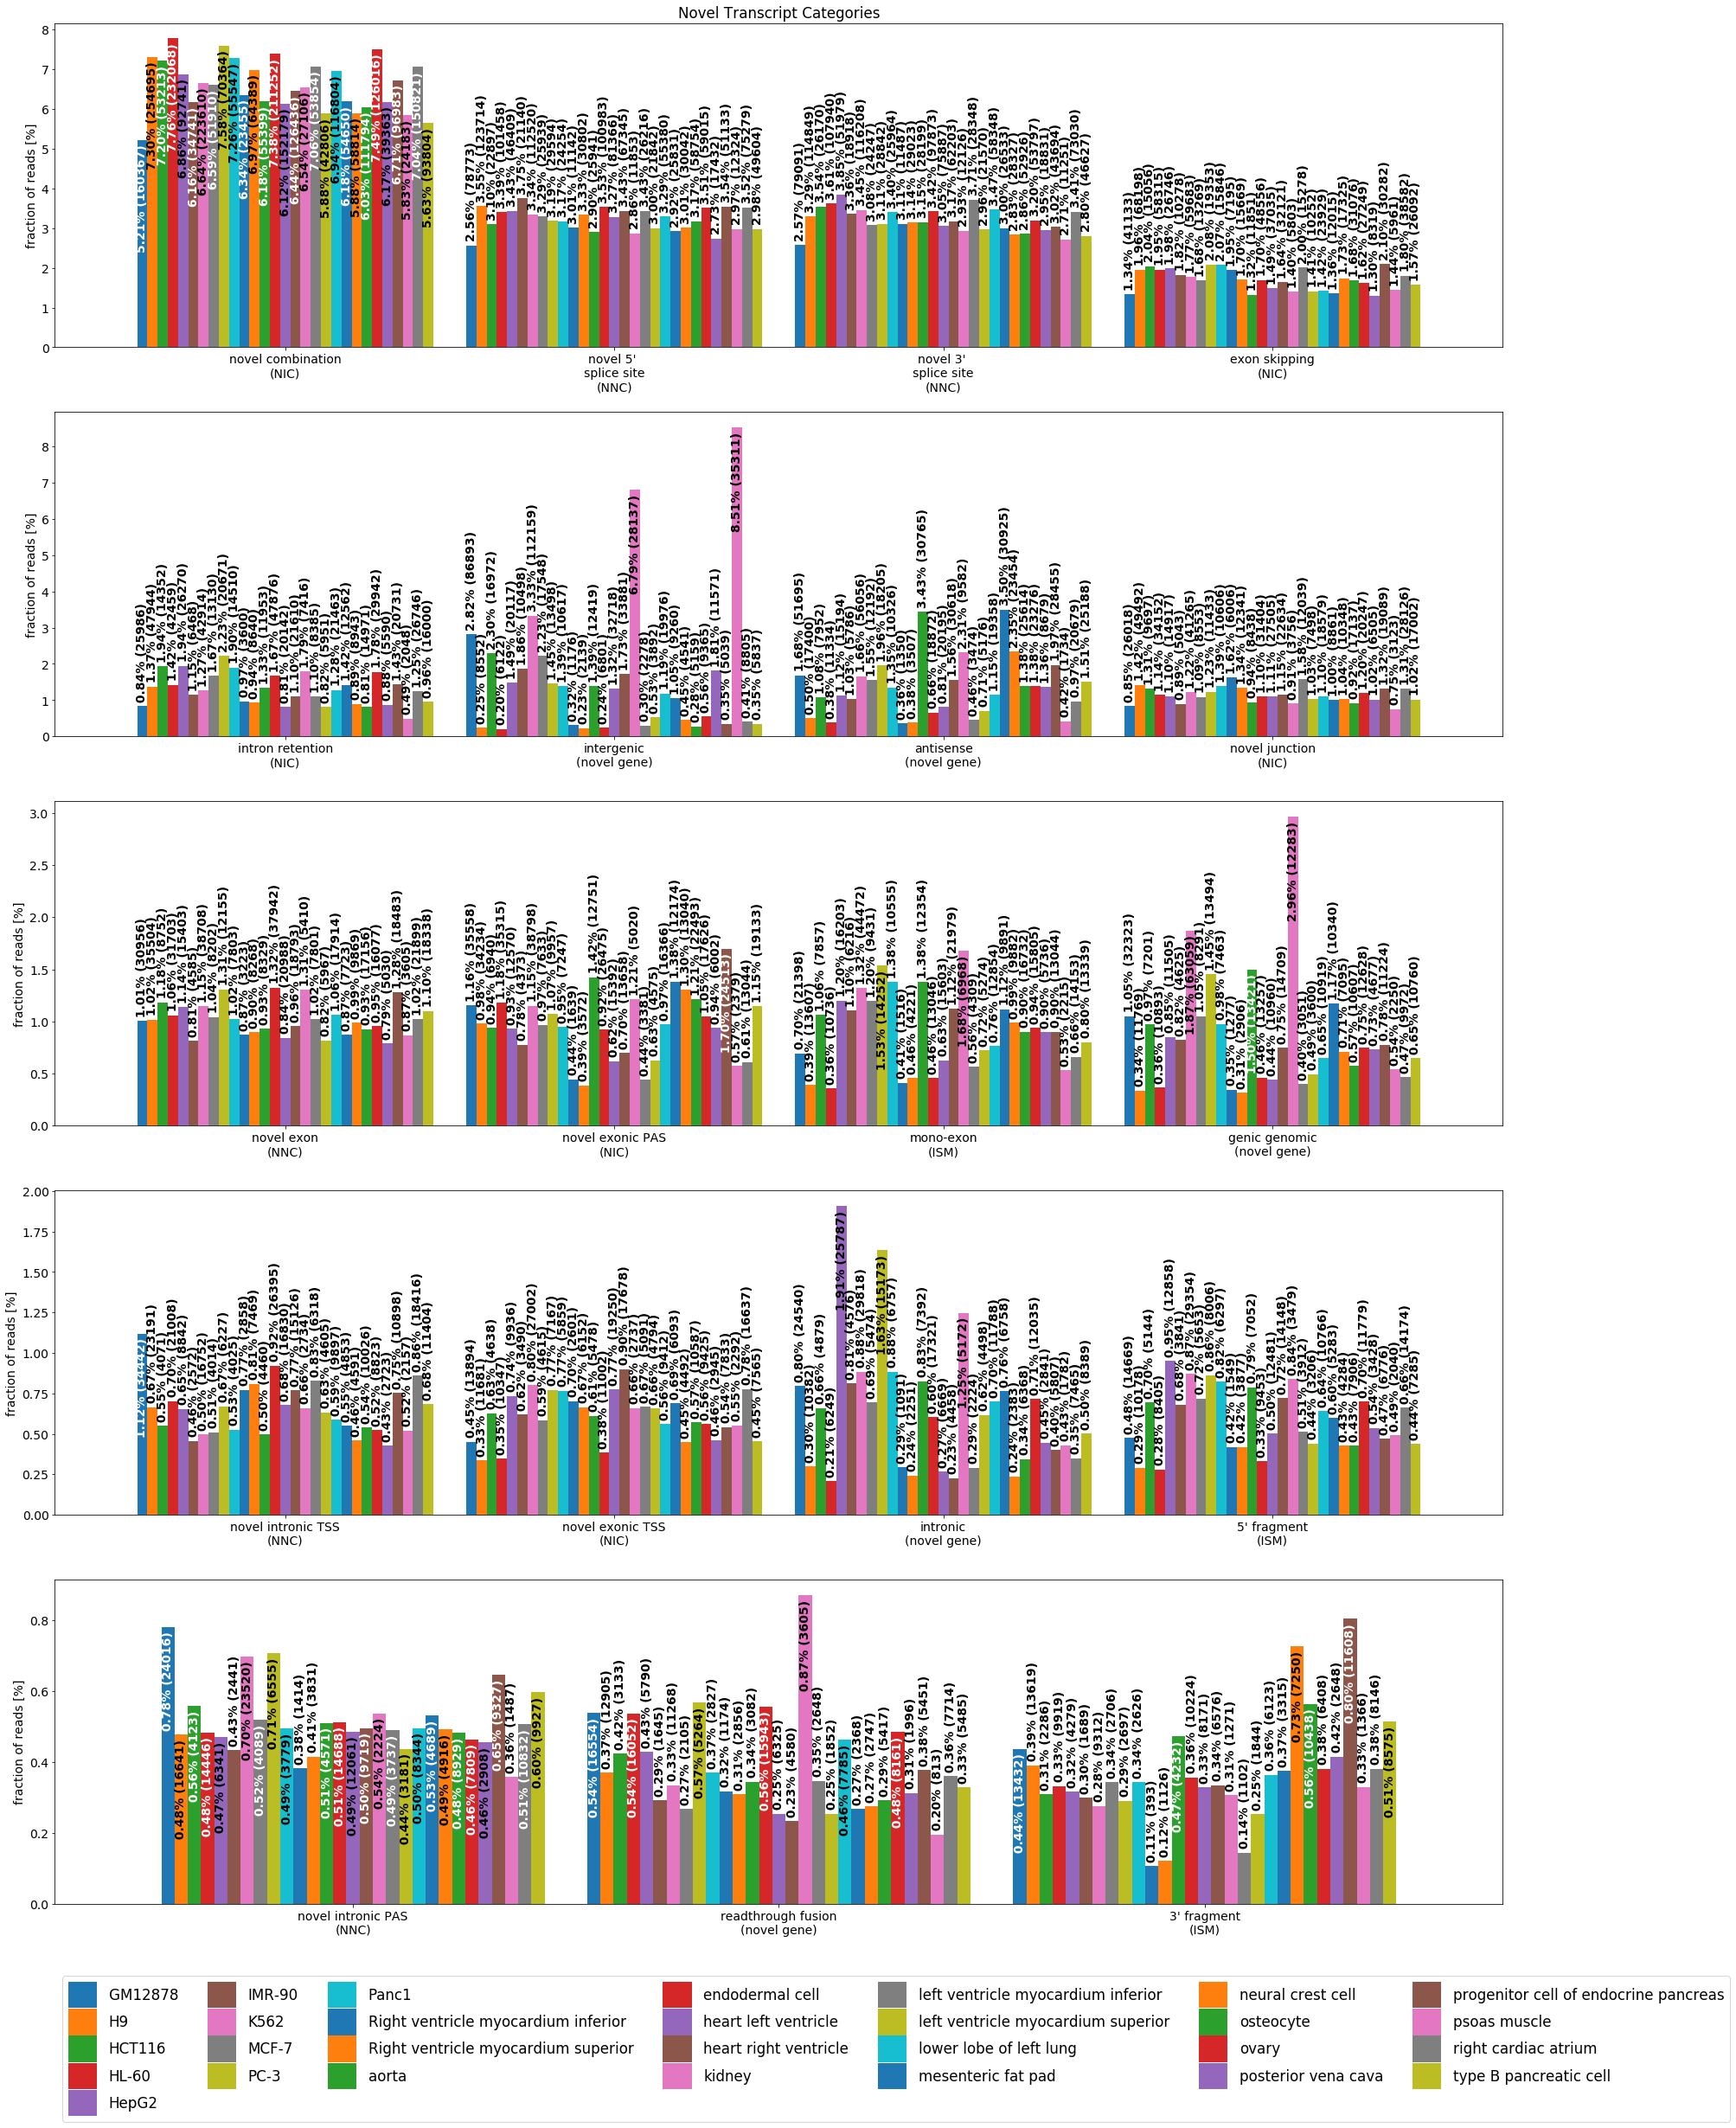

In [15]:
from isotools.plots import plot_bar, plot_distr

plt.rcParams["figure.figsize"] = (30,40)
fig, axs = plt.subplots( 5)
for i,ax in enumerate(axs):
    cat=altsplice[0][0].index[i*4+2:(i+1)*4+2]
    plot_bar(altsplice[0][0],bar_width=.9,ax=ax,ylabel='fraction of reads [%]', legend=False, rot=0,drop_categories=[c for c in altsplice[0][0].index if c not in cat])  
axs[-1].legend(fontsize='large', ncol=7,handleheight=2.4, labelspacing=0.05, bbox_to_anchor=(0, -.2), loc='upper left')
_=axs[0].set_title('Novel Transcript Categories')

In [16]:
#The same for individual samples
altsplice_sample= isoseq.altsplice_stats( weight_by_coverage=True, min_coverage=1, tr_filter=dict( remove=['RTTS', 'FRAGMENT', 'INTERNAL_PRIMING']))
altsplice_sample[0].index=altsplice_sample[0].index+[f'\n({cname[cnr[subcat]]})' if subcat in cnr else '' for subcat in altsplice_sample[0].index]


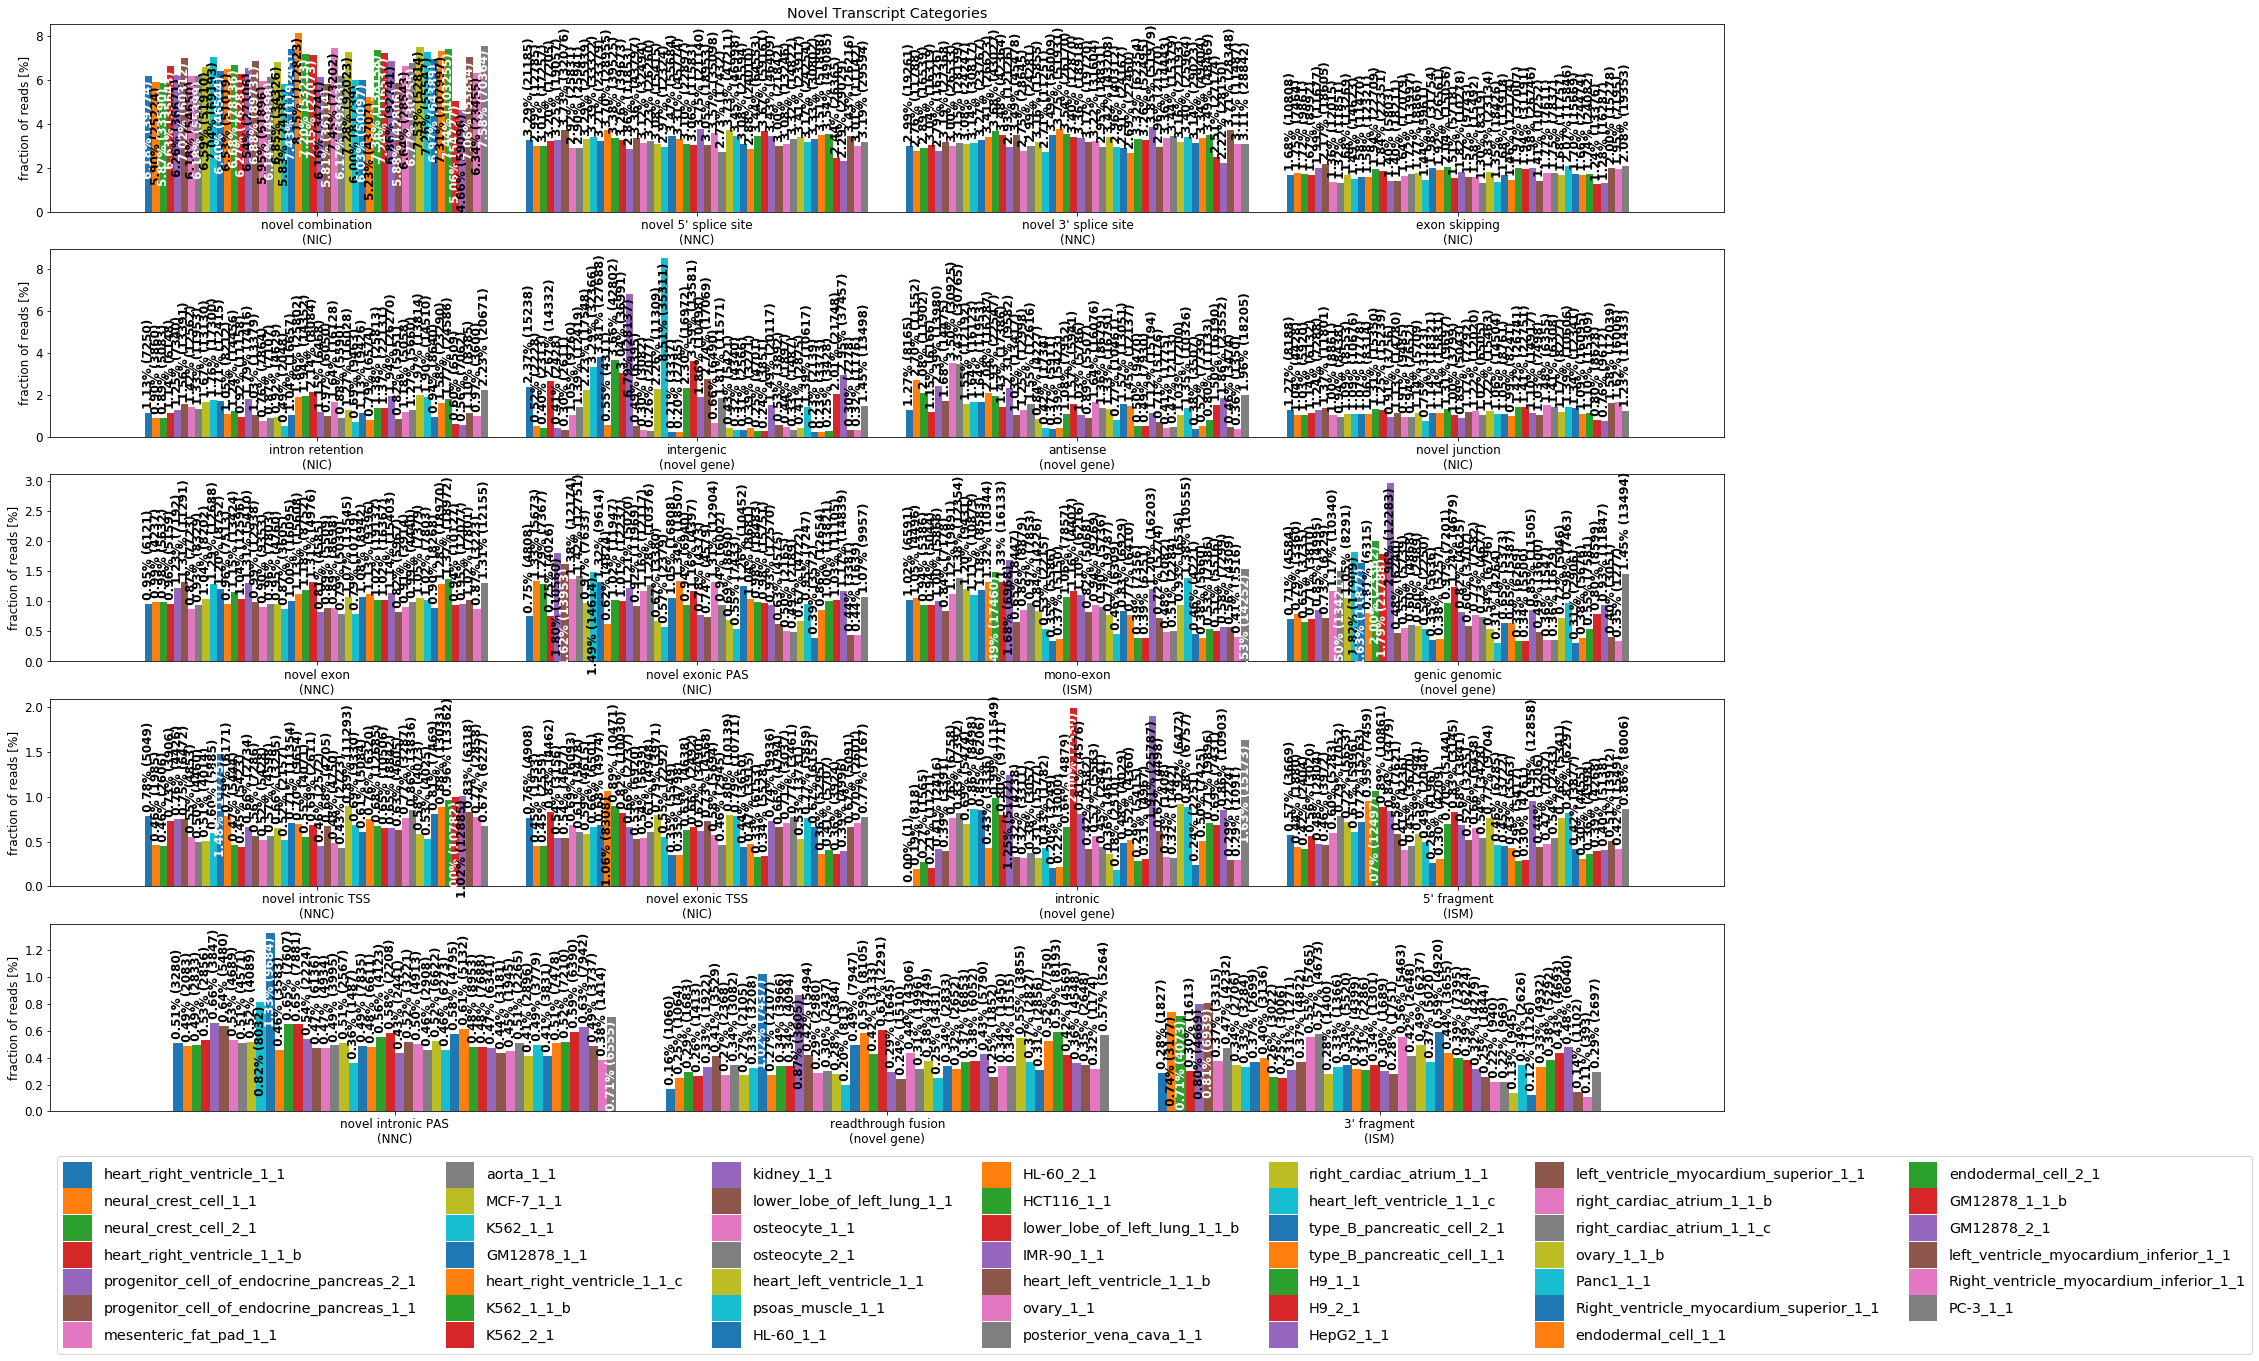

In [17]:
plt.rcParams["figure.figsize"] = (30,20)
plt.rcParams.update({'font.size': 12})
fig, axs = plt.subplots( 5)


for i,ax in enumerate(axs.flatten()):
    cat=altsplice_sample[0].index[i*4+2:(i+1)*4+2]
    plot_bar(altsplice_sample[0],bar_width=.9,ax=ax,ylabel='fraction of reads [%]', legend=False, rot=0,drop_categories=[c for c in altsplice_sample[0].index if c not in cat])  
handles, labels = axs[0].get_legend_handles_labels()

axs[-1].legend(fontsize='large', ncol=7,handleheight=2.4, labelspacing=0.05, bbox_to_anchor=(0, -.2), loc='upper left')
_=axs[0].set_title('Novel Transcript Categories')

## Differential splicing

To test for differential splicing events between groups of samples, IsoTools implements a likelihood ratio test based on beta binomial distribution. 
For each alternative event, the number of reads supporting the alternative is modeled with a binomial distribution, where the probability parmeter is beta distributed. For the null model, we fit one set of maximum likelihood parameters of the beta distribution for all samples, whereas for the alternative model, a set of parameters if fitted for each group. Under the null hypothesis, the model deviance is assumed to follow a chi2 distribution with two degrees of freedom.

Each comparision results in table of alternative splicing events, sorted by significance. 
To explore the results, we can plot the fitted maximum likelihood beta distributions of the alternative model for the most significant events.
We can also look at individual examples and depict the event as a sashimi plot. 
To this end, we define a helper function, to automatically identify the relevant region and the involved junctions and make the sashimi plot:


In [18]:
#first we define a function, to depcit the results
def plot_diff_example(row, isoseq, groups):
    #sashimi plot for differential spliced genes
    plt.rcParams["figure.figsize"] = (15,10)
    #select gene object
    g=isoseq[row.gene_id]
    #make the title
    gn=list(groups)
    novel='novel' if row.novel else 'known'
    title=f'{g.name} {row.splice_type} ({novel}) FDR={row.padj:.2e}: {gn[0]}={row[gn[0]+"_PSI"]*100:.1f} vs {gn[1]}={row[gn[1]+"_PSI"]*100:.1f} PSI'
    print(title)
    start=row.start
    end=row.end
    #select the junctions of interest (which will be marked purple in the plot)
    joi=[(start,end)]
    if row.splice_type=='ME' and g.is_annotated:
        try:
            sg=g.ref_segment_graph
            n1=next(n for n in sg if n[1]==start)
            n2=next(n for n in sg if n[0]==end)
            joi={(start,sg[suc].start) for suc in n1.suc.values() if sg[suc].start<end }
            joi.update({(sg[pre].end,end) for pre in n2.pre.values() if sg[pre].end>start })
        except:
            pass
    #draw the plot for the two sample groups from the comparison
    f,axs=g.sashimi_figure(samples=groups , x_range=(start-500, end+500),junctions_of_interest=joi    )
    axs[0].set_title(title)
    fig.tight_layout()

In [19]:
from isotools.plots import plot_diff_results
#We are mostly interested in differential splicing. Alternative TSS and PAS are ignored for now. 
types_of_interest=['ES','ME','5AS','3AS']
#dict to store the results in
res={}

### Normal endodermal development
As a first example, we compare the embryonic stem cell line H9 vs in vitro derived endodermal cells.

In [20]:
diff_cmp='H9/endodermal cell'
groups={k:isoseq.groups()[k] for k in diff_cmp.split('/')}

#takes about 20 min
res[diff_cmp]=isoseq.altsplice_test(groups).sort_values('pvalue').reset_index()
res[diff_cmp].to_csv(f'encode_diff_betabinomial_{"_".join(groups)}.csv', index=False)
#res[diff_cmp]=pd.read_csv(f'encode_diff_betabinomial_{"_".join(groups)}.csv')
sig=res[diff_cmp].padj<.1
print(f'{sum(sig)} differential splice sites in {len(res[diff_cmp].loc[sig,"gene"].unique())} genes for {" vs ".join(groups)}')
res[diff_cmp][res[diff_cmp].splice_type.isin(types_of_interest)].head(10)

INFO:testing differential splicing for H9 (2) vs endodermal cell (2) using betabinom_lr test
100%|██████████| 571113/571113 [14:32<00:00, 654.38it/s] 


372 differential splice sites in 269 genes for H9 vs endodermal cell


index   gene             gene_id  chrom strand      start        end  \
0    9067   DDX5  ENSG00000108654.16  chr17      -   64500326   64502009   
14    832  CCNL2  ENSG00000221978.12   chr1      -    1390865    1393395   
15   6082   OTX2  ENSG00000165588.18  chr14      -   56802355   56805359   
20   8635   WSB1  ENSG00000109046.15  chr17      +   27306882   27309099   
30  20358  LAS1L  ENSG00000001497.18   chrX      -   65524262   65524964   
31   9068   DDX5  ENSG00000108654.16  chr17      -   64500326   64502009   
33  15623  HMGCR  ENSG00000113161.16   chr5      +   75354697   75355364   
35  15978   BRD8  ENSG00000112983.18   chr5      -  138166108  138167933   
40  15727  HARS1  ENSG00000170445.16   chr5      -  140678015  140679061   
42  12885  PRMT2  ENSG00000160310.18  chr21      +   46635763   46636895   

   splice_type  novel      padj  ...  total_PSI  total_disp  H9_1_1_H9_in_cov  \
0          5AS   True  0.066432  ...   0.597657    0.096982                57   
14         3AS  False  0.066432  ...   0.603724    0.035540               104   
15          ES  False  0.068731  ...   0.824694    0.005527              1406   
20         3AS  False  0.068800  ...   0.325741    0.033853                78   
30          ES  False  0.070701  ...   0.186298    0.009080               221   
31         3AS   True  0.070701  ...   0.552004    0.083533                60   
33          ES  False  0.070701  ...   0.774301    0.010418               433   
35          ES  False  0.070701  ...   0.641522    0.025700               122   
40         5AS  False  0.071538  ...   0.858092    0.008208               552   
42          ES  False  0.071538  ...   0.451093    0.024672               290   

    H9_1_1_H9_total_cov  H9_2_1_H9_in_cov  H9_2_1_H9_total_cov  \
0                   248                46                  235   
14                  255                87                  224   
15                 1856              1134                 1528   
20                  610                78                  565   
30                  769               190                  684   
31                  251                42                  231   
33                  654               414                  611   
35                  268               114                  235   
40                  712               491                  644   
42                  461               247                  408   

    endodermal_cell_1_1_endodermal cell_in_cov  \
0                                          216   
14                                         375   
15                                        1697   
20                                         258   
30                                          47   
31                                         119   
33                                         621   
35                                         300   
40                                         369   
42                                         191   

    endodermal_cell_1_1_endodermal cell_total_cov  \
0                                             229   
14                                            464   
15                                           1884   
20                                            523   
30                                            528   
31                                            132   
33                                            713   
35                                            370   
40                                            391   
42                                            626   

    endodermal_cell_2_1_endodermal cell_in_cov  \
0                                          236   
14                                         360   
15                                        1619   
20                                         331   
30                                          43   
31                                          84   
33                                         680   
35           

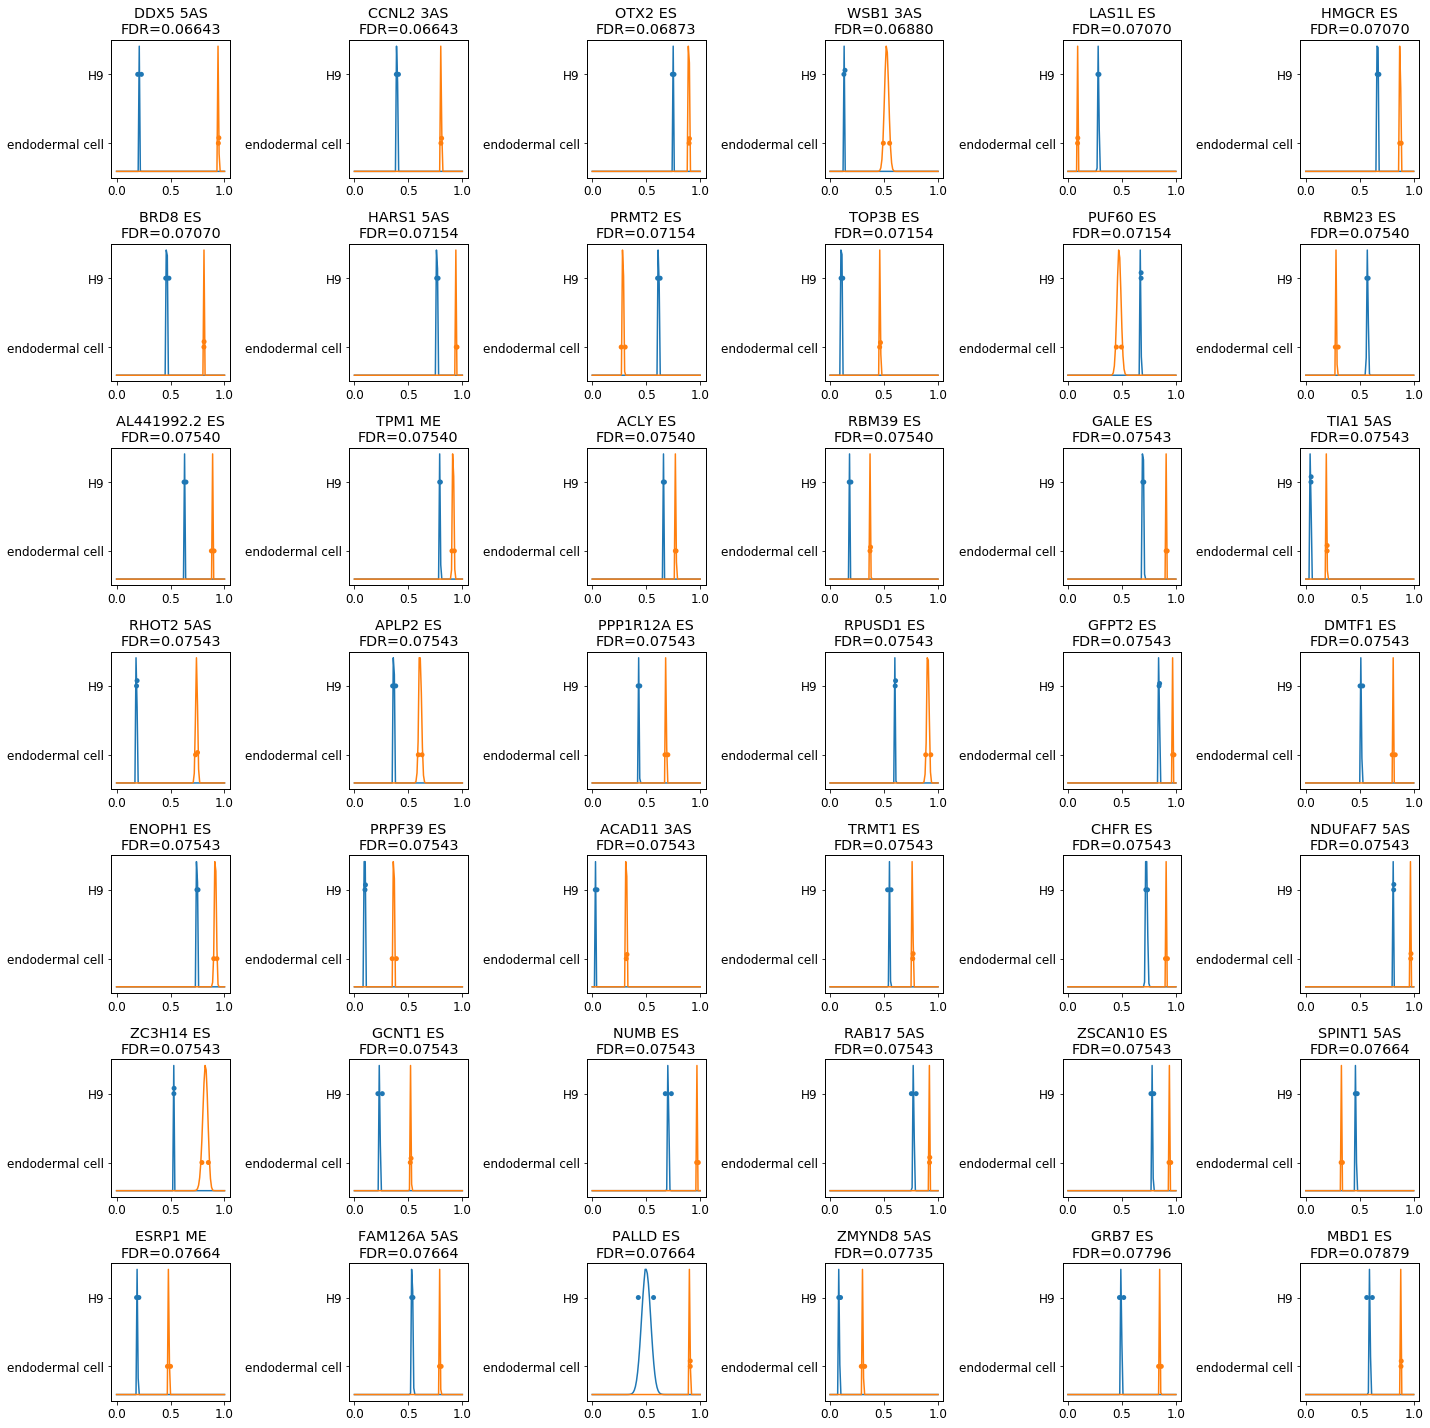

In [21]:
#plot the fitted maximum likelihood beta distributions of the alternative model for the most significant events.
plt.rcParams["figure.figsize"] = (20,20)
f,axs,plotted=plot_diff_results(res[diff_cmp], min_diff=.1,grid_shape=(7,6),min_support=2, splice_types=types_of_interest)
f.savefig(f'encode_diff_betabinomial_{"_".join(groups)}.png')
plotted.to_csv(f'encode_diff_betabinomial_plot_{"_".join(groups)}.csv', index=False)

OTX2 ES (known) FDR=6.87e-02: H9=75.1 vs endodermal cell=89.9 PSI


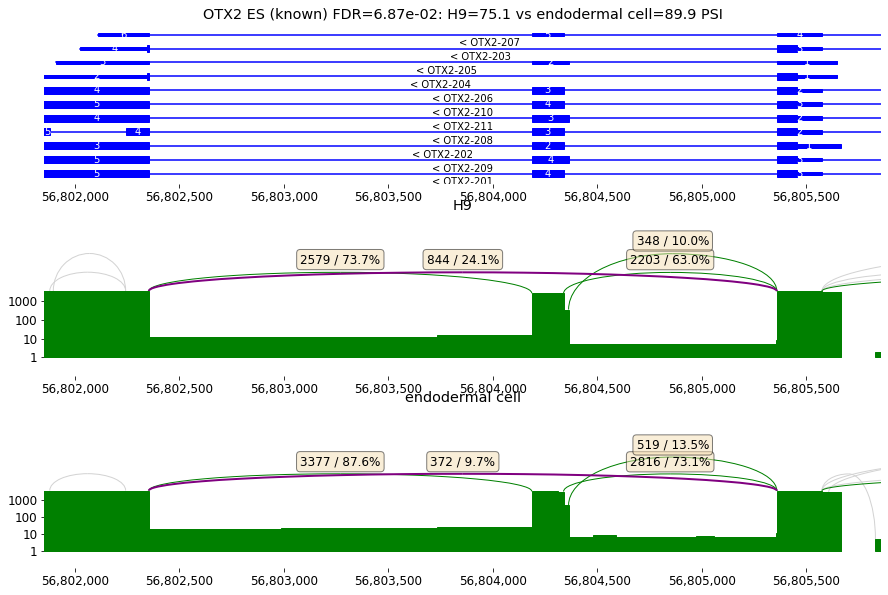

In [43]:
#sashimi plot for differential spliced genes
plt.rcParams["figure.figsize"] = (15,10)
#1) select gene of interest
row=res[diff_cmp].iloc[15]
plot_diff_example(row, isoseq, groups)

### Leukemia cell lines
Both leukemia cell lines HL-60 and K562 (should) have mutations in the splicing machinery, e.g. in the SRSF2 gene, which should lead to abberant splicing. We compare them to the B-cell derived cell line GM12878.

See Urbanski et al: Alternative-splicing defects in cancer: splicing regulators and their downstream targets, guiding the way to novel cancer therapeutics
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6002934/


In [23]:
diff_cmp='GM12878/HL-60'
groups={k:isoseq.groups()[k] for k in diff_cmp.split('/')}

#
#takes about 30 min
res[diff_cmp]=isoseq.altsplice_test(groups).sort_values('pvalue').reset_index()
res[diff_cmp].to_csv(f'encode_diff_betabinomial_{"_".join(groups)}.csv', index=False)
#res[diff_cmp]=pd.read_csv(f'encode_diff_betabinomial_{"_".join(groups)}.csv')
sig=res[diff_cmp].padj<.1
print(f'{sum(sig)} differential splice sites in {len(res[diff_cmp].loc[sig,"gene"].unique())} genes for {" vs ".join(groups)}')
res[diff_cmp][res[diff_cmp].splice_type.isin(types_of_interest)].head(10)

INFO:testing differential splicing for GM12878 (3) vs HL-60 (2) using betabinom_lr test
100%|██████████| 571113/571113 [13:10<00:00, 722.31it/s] 


5792 differential splice sites in 3401 genes for GM12878 vs HL-60


index     gene             gene_id  chrom strand      start        end  \
3   12405   EIF4A2  ENSG00000156976.17   chr3      +  186787882  186789124   
4   12406   EIF4A2  ENSG00000156976.17   chr3      +  186787882  186789124   
9    3742   ANAPC5  ENSG00000089053.13  chr12      -  121328458  121330582   
12  15720     MCM3  ENSG00000112118.20   chr6      -   52264786   52266074   
13  10234    CBWD2  ENSG00000136682.15   chr2      +  113438022  113441350   
17  16806  METTL2B  ENSG00000165055.16   chr7      +  128476875  128479157   
20   5651   ZNF410  ENSG00000119725.20  chr14      +   73921105   73923394   
21    385     SRP9  ENSG00000143742.14   chr1      +  225783368  225789239   
23   7937     WSB1  ENSG00000109046.15  chr17      +   27306882   27309099   
24   1084   LGALS8  ENSG00000116977.19   chr1      +  236542787  236543559   

   splice_type  novel      padj  ...  GM12878_1_1_GM12878_in_cov  \
3           ES  False  0.003988  ...                          49   
4          3AS   True  0.004463  ...                          39   
9          3AS  False  0.006980  ...                         201   
12          ES  False  0.006980  ...                          22   
13          ES  False  0.006980  ...                          12   
17          ES  False  0.006980  ...                           3   
20          ES  False  0.007574  ...                          97   
21          ES  False  0.007574  ...                          24   
23         3AS  False  0.007574  ...                           6   
24          ES  False  0.007574  ...                          13   

    GM12878_1_1_GM12878_total_cov  GM12878_1_1_b_GM12878_in_cov  \
3                             132                           234   
4                             122                           211   
9                             305                           895   
12                            704                            47   
13                             88                            24   
17                             44                             5   
20                            147                           342   
21                            266                            95   
23                             63                            25   
24                             17                            82   

    GM12878_1_1_b_GM12878_total_cov  GM12878_2_1_GM12878_in_cov  \
3                               708                         333   
4                               685                         250   
9                              1340                        1169   
12                             2403                          31   
13                              209                          37   
17                               88                           9   
20                              511                         524   
21                             1453                         173   
23                              403                          21   
24                              111                         107   

    GM12878_2_1_GM12878_total_cov  HL-60_1_1_HL-60_in_cov  \
3                             966                    47.0   
4                             883                    25.0   
9                            1727                   470.0   
12                           1979                   519.0   
13                            326                   135.0   
17                            144                   122.0   
20                            808                   360.0   
21                           2368                   305.0   
23                            621                   101.0   
24                            150                    14.0   

    HL-60_1_1_HL-60_total_cov  HL-60_2_1_HL-60_in_cov  \
3                      1748.0                    26.0   
4                      1726.0                    14.0   
9                      1206.0                   404.0   
12                  

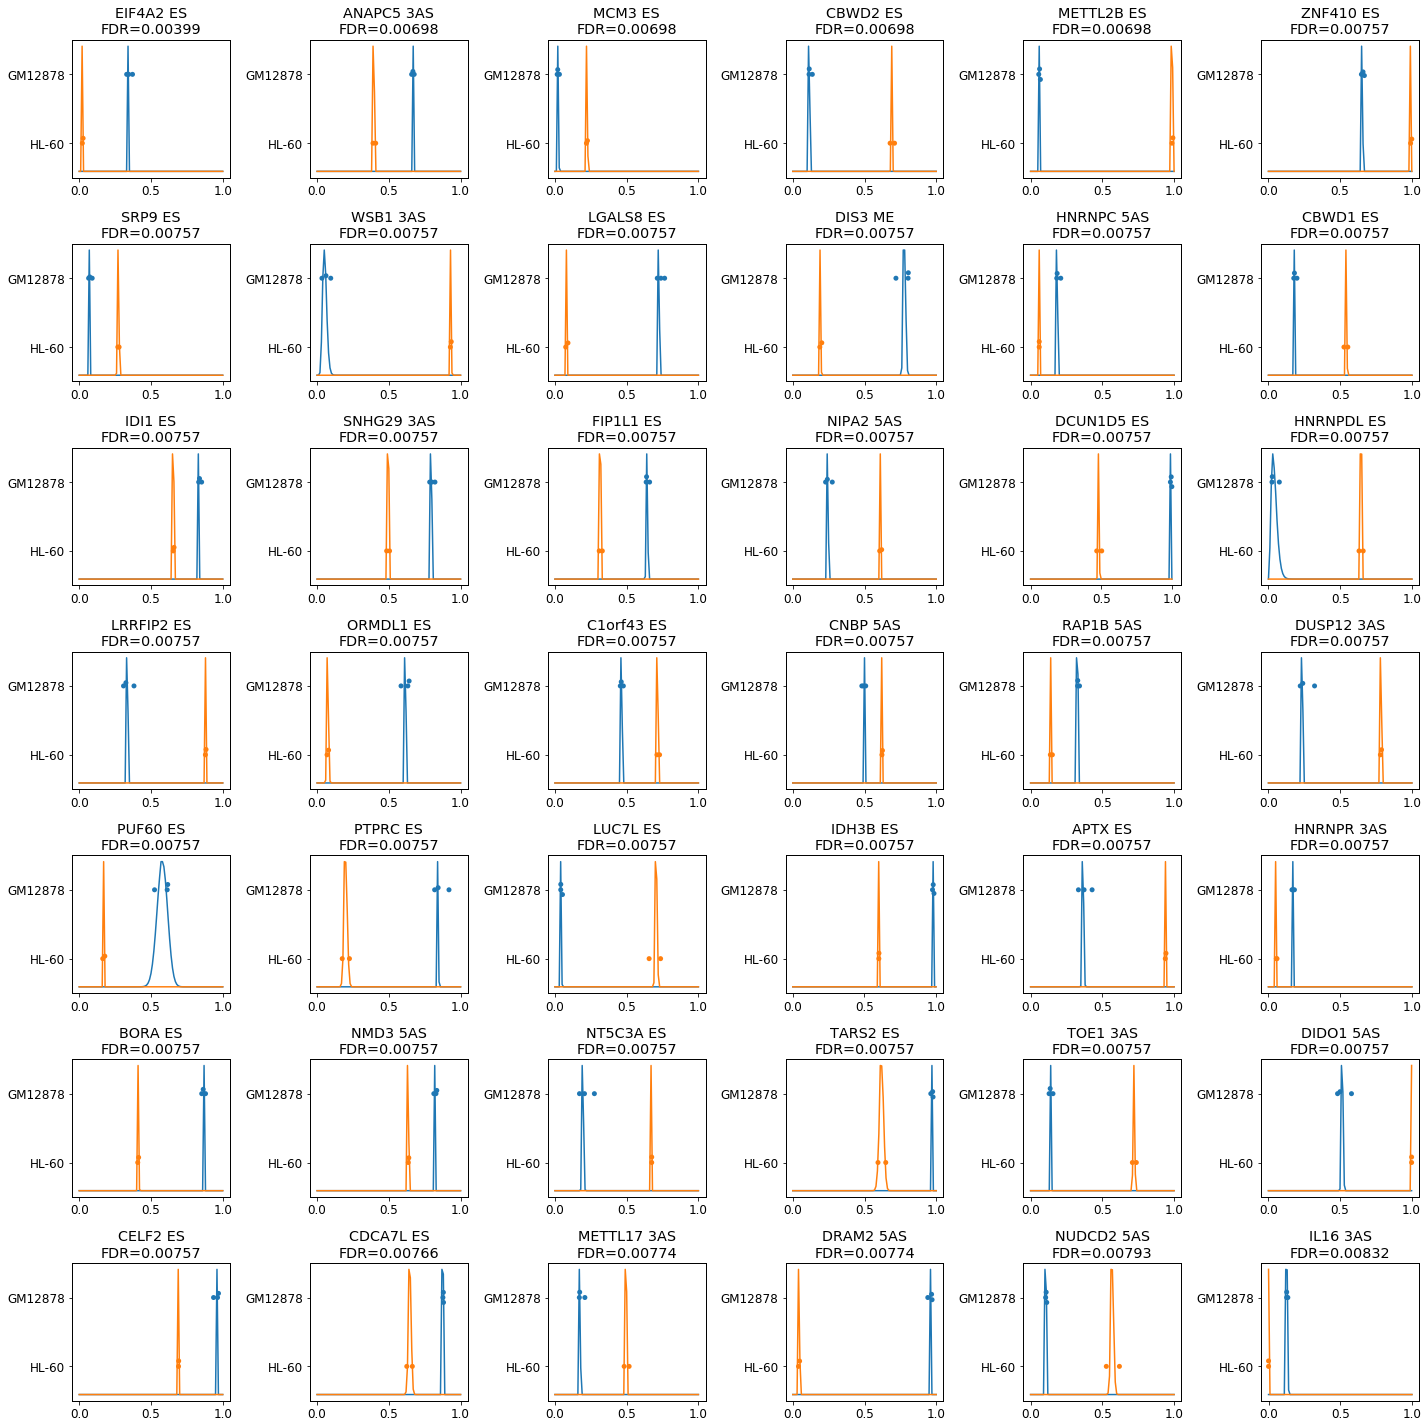

In [24]:

plt.rcParams["figure.figsize"] = (20,20)
f,axs,plotted=plot_diff_results(res[diff_cmp], min_diff=.1,grid_shape=(7,6),min_support=2, splice_types=types_of_interest)
f.savefig(f'encode_diff_betabinomial_{"_".join(groups)}.png')
plotted.to_csv(f'encode_diff_betabinomial_plot_{"_".join(groups)}.csv', index=False)

EIF4A2 ES (known) FDR=3.99e-03: GM12878=34.1 vs HL-60=2.5 PSI


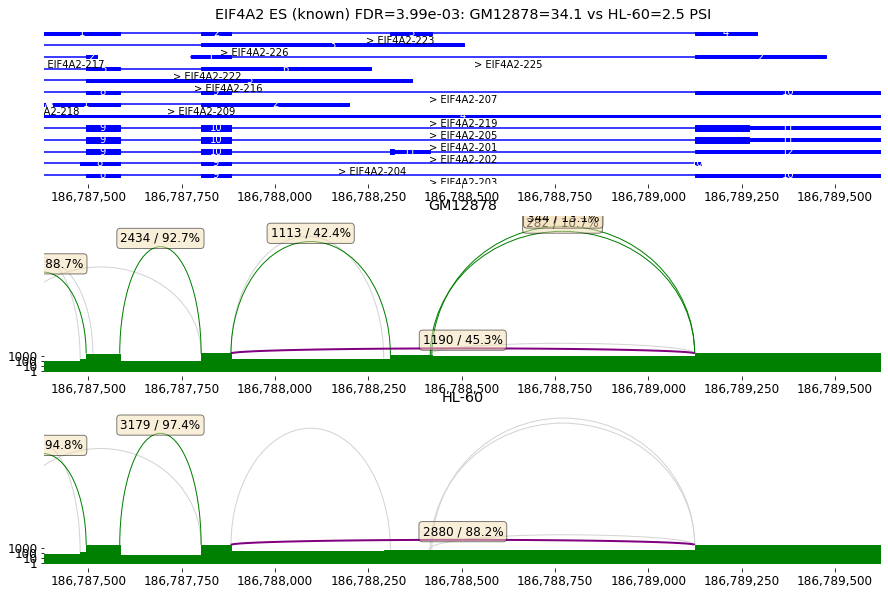

In [45]:
#sashimi plot for differential spliced genes
plt.rcParams["figure.figsize"] = (15,20)
#1) select gene of interest: 3nd row, exon skipping of EIF4A2
row=res[diff_cmp].iloc[3]
plot_diff_example(row, isoseq, groups)

In [26]:
diff_cmp='GM12878/K562'
groups={k:isoseq.groups()[k] for k in diff_cmp.split('/')}

#takes about 30 min
res[diff_cmp]=isoseq.altsplice_test(groups).sort_values('pvalue').reset_index()
res[diff_cmp].to_csv(f'encode_diff_betabinomial_{"_".join(groups)}.csv', index=False)
#res[diff_cmp]=pd.read_csv(f'encode_diff_betabinomial_{"_".join(groups)}.csv')
sig=res[diff_cmp].padj<.1
print(f'{sum(sig)} differential splice sites in {len(res[diff_cmp].loc[sig,"gene"].unique())} genes for {" vs ".join(groups)}')
res[diff_cmp][res[diff_cmp].splice_type.isin(types_of_interest)].head(10)

INFO:testing differential splicing for GM12878 (3) vs K562 (3) using betabinom_lr test
100%|██████████| 571113/571113 [15:18<00:00, 621.97it/s] 


4738 differential splice sites in 3102 genes for GM12878 vs K562


index      gene             gene_id  chrom strand      start        end  \
0    2264    NDUFS5  ENSG00000168653.11   chr1      +   39026398   39028722   
5   20769     RIPK2   ENSG00000104312.8   chr8      +   89780160   89786592   
8    1353     PSMB2  ENSG00000126067.12   chr1      -   35631344   35641341   
9    5038      MYL6  ENSG00000092841.19  chr12      +   56160320   56161386   
14  16651     CASP3  ENSG00000164305.19   chr4      -  184638468  184649394   
20   4985  RAD51AP1  ENSG00000111247.15  chr12      +    4553147    4558856   
21   6407    HNRNPC  ENSG00000092199.18  chr14      -   21230366   21230996   
22  19707   METTL2B  ENSG00000165055.16   chr7      +  128476875  128479157   
33  21259     CBWD1  ENSG00000172785.18   chr9      -     175784     178815   
38   2267     MPZL1  ENSG00000197965.12   chr1      +  167773368  167787819   

   splice_type  novel      padj  ...  GM12878_1_1_b_GM12878_in_cov  \
0          5AS  False  0.001048  ...                             5   
5           ES   True  0.004188  ...                           217   
8           ES   True  0.005450  ...                           550   
9           ES  False  0.005450  ...                            16   
14          ES   True  0.005450  ...                           157   
20          ES  False  0.006884  ...                            43   
21         5AS  False  0.007219  ...                           325   
22          ES  False  0.007219  ...                             5   
33          ES  False  0.007509  ...                            60   
38          ES  False  0.010949  ...                             0   

    GM12878_1_1_b_GM12878_total_cov  GM12878_2_1_GM12878_in_cov  \
0                               393                           7   
5                               219                         224   
8                               550                         954   
9                              1494                          24   
14                              720                         197   
20                               48                          45   
21                             1784                         387   
22                               88                           9   
33                              302                          99   
38                                2                           0   

    GM12878_2_1_GM12878_total_cov  K562_1_1_K562_in_cov  \
0                             634                   136   
5                             225                    41   
8                             954                   262   
9                            1827                   182   
14                            958                    71   
20                             49                     7   
21                           2092                   361   
22                            144                    71   
33                            561                    50   
38                              4                   124   

    K562_1_1_K562_total_cov  K562_1_1_b_K562_in_cov  \
0                       249                     208   
5                       152                      34   
8                       341                     681   
9                       611                     188   
14                       95                      71   
20                       41                       5   
21                     1094                     431   
22                       71                      69   
33                      112                     107   
38                      190                     168   

    K562_1_1_b_K562_total_cov  K562_2_1_K562_in_cov  K562_2_1_K562_total_cov  
0                         372                   337                      581  
5                         104                    33                      112  
8                         893                   595                      765  
9                         722                   235  

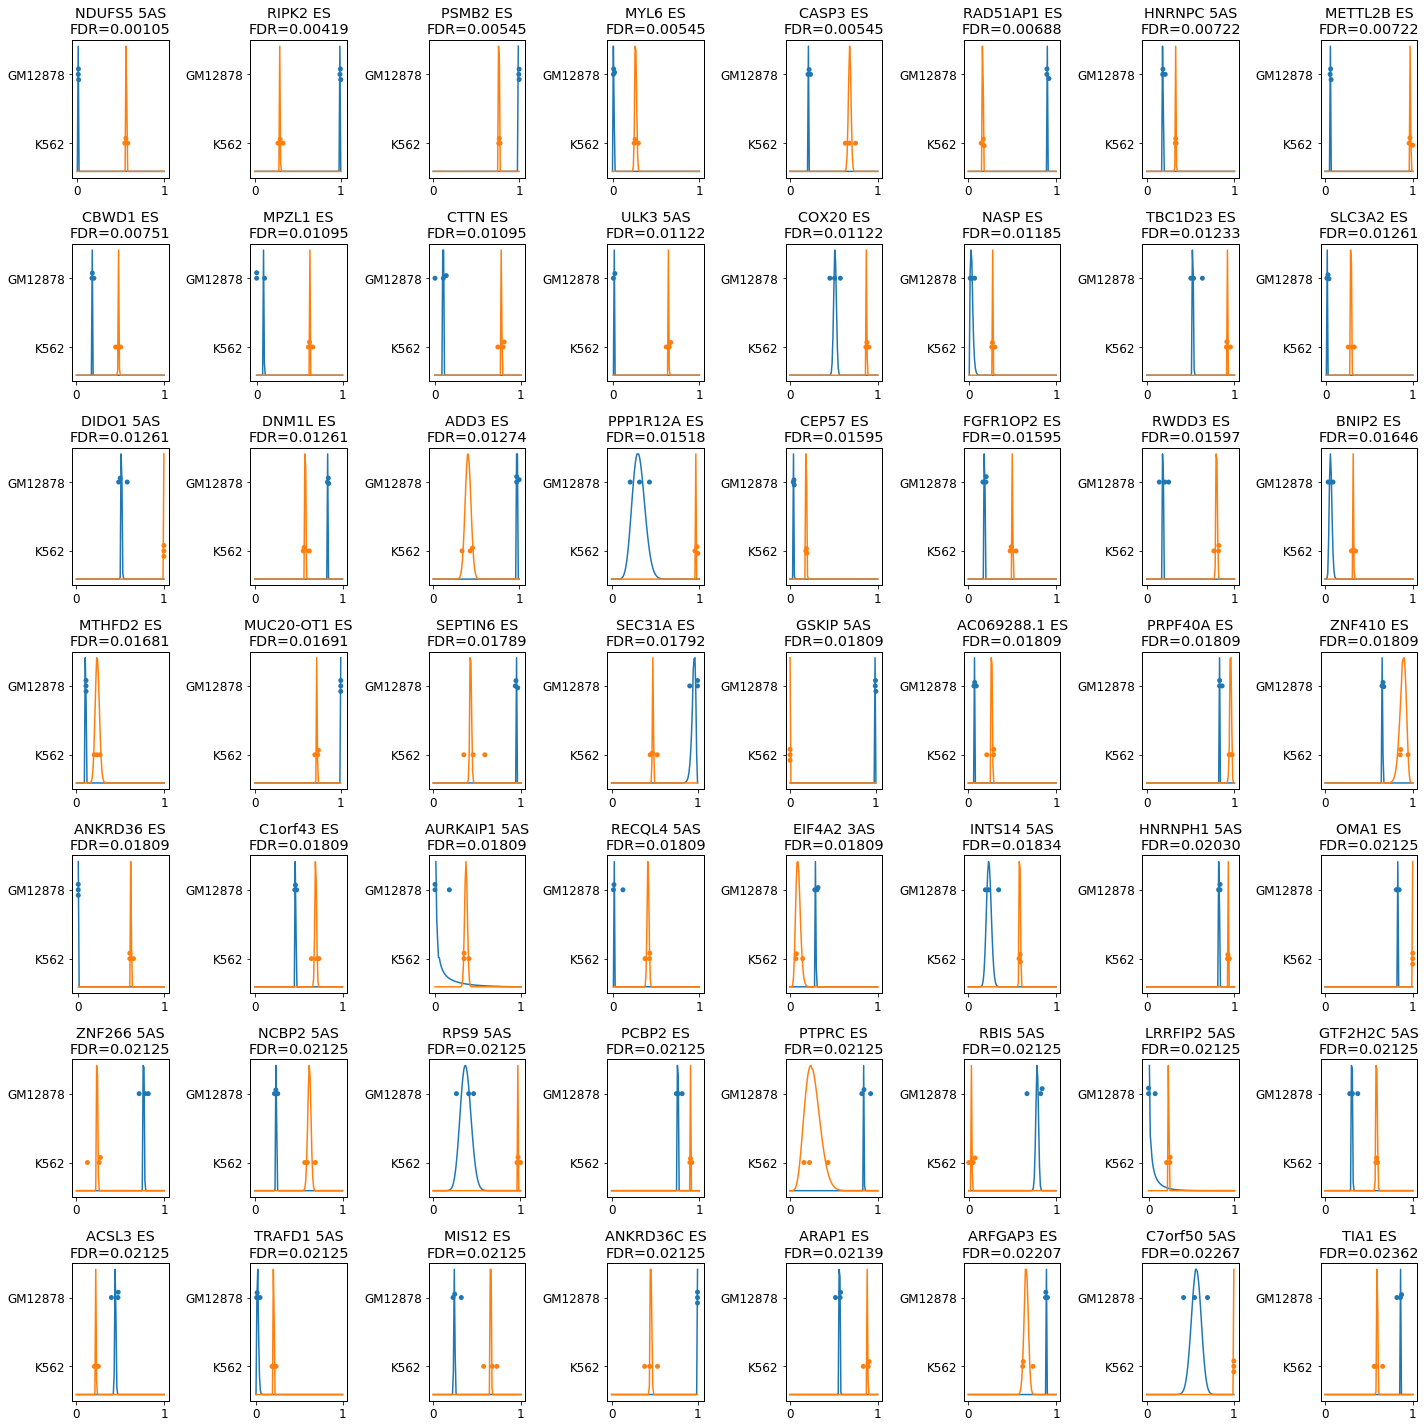

In [27]:

plt.rcParams["figure.figsize"] = (20,20)
f,axs,plotted=plot_diff_results(res[diff_cmp], min_diff=.1,grid_shape=(7,8),min_support=2, splice_types=types_of_interest)
f.savefig(f'encode_diff_betabinomial_{"_".join(groups)}.png')
plotted.to_csv(f'encode_diff_betabinomial_plot_{"_".join(groups)}.csv', index=False)

RIPK2 ES (novel) FDR=4.19e-03: GM12878=99.4 vs K562=29.4 PSI


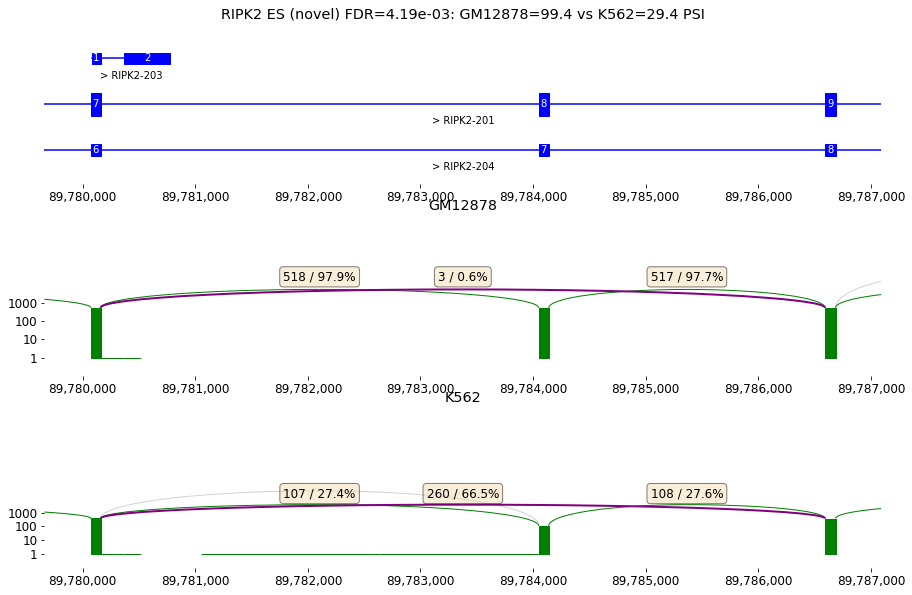

In [47]:
#sashimi plot for differential spliced genes
plt.rcParams["figure.figsize"] = (15,10)
#1) select gene of interest
row=res[diff_cmp].iloc[5]
plot_diff_example(row, isoseq, groups)

In [29]:
gr=isoseq.groups()
groups={'leukemia':gr['K562']+gr['HL-60'], 'GM12878':gr['GM12878']}
diff_cmp='/'.join(groups)

#takes about 30 min
res[diff_cmp]=isoseq.altsplice_test(groups).sort_values('pvalue').reset_index()
res[diff_cmp].to_csv(f'encode_diff_betabinomial_{"_".join(groups)}.csv', index=False)
#res[diff_cmp]=pd.read_csv(f'encode_diff_betabinomial_{"_".join(groups)}.csv')
sig=res[diff_cmp].padj<.1
print(f'{sum(sig)} differential splice sites in {len(res[diff_cmp].loc[sig,"gene"].unique())} genes for {" vs ".join(groups)}')
res[diff_cmp][res[diff_cmp].splice_type.isin(types_of_interest)].head(10)

INFO:testing differential splicing for leukemia (5) vs GM12878 (3) using betabinom_lr test
100%|██████████| 571113/571113 [15:31<00:00, 613.13it/s] 


1563 differential splice sites in 1170 genes for leukemia vs GM12878


index        gene             gene_id  chrom strand      start        end  \
2   21219     METTL2B  ENSG00000165055.16   chr7      +  128476875  128479157   
8   22839       CBWD1  ENSG00000172785.18   chr9      -     175784     178815   
9    2385      NDUFS5  ENSG00000168653.11   chr1      +   39026398   39028722   
12   1204     C1orf43  ENSG00000143612.21   chr1      -  154214574  154220341   
15    866       ACADM  ENSG00000117054.14   chr1      +   75724817   75732643   
16   8054      INTS14  ENSG00000138614.15  chr15      -   65607442   65611097   
17  20354  AC069288.1   ENSG00000286192.1   chr7      -    2235564    2239417   
25  19862      ECHDC1  ENSG00000093144.19   chr6      -  127314896  127327001   
29  14480       DIDO1  ENSG00000101191.17  chr20      -   62914406   62926438   
30   1861       PTPRC  ENSG00000081237.20   chr1      +  198692373  198703297   

   splice_type  novel      padj  ...  HL-60_1_1_leukemia_in_cov  \
2           ES  False  0.001650  ...                        122   
8           ES  False  0.002585  ...                        192   
9          5AS  False  0.002741  ...                         17   
12          ES  False  0.004014  ...                       1157   
15          ES  False  0.004014  ...                        264   
16         5AS  False  0.004014  ...                        135   
17          ES   True  0.004014  ...                         92   
25          ES  False  0.005165  ...                        149   
29         5AS   True  0.005165  ...                        175   
30          ES  False  0.005165  ...                         67   

    HL-60_1_1_leukemia_total_cov  HL-60_2_1_leukemia_in_cov  \
2                            123                         67   
8                            347                        120   
9                             44                         13   
12                          1627                        768   
15                           325                        206   
16                           224                        110   
17                           343                         72   
25                           273                        110   
29                           175                        156   
30                           297                         58   

    HL-60_2_1_leukemia_total_cov  GM12878_1_1_GM12878_in_cov  \
2                             68                           3   
8                            228                          25   
9                             43                           3   
12                          1053                          49   
15                           256                         155   
16                           180                          19   
17                           286                           9   
25                           211                          68   
29                           156                          29   
30                           331                          57   

    GM12878_1_1_GM12878_total_cov  GM12878_1_1_b_GM12878_in_cov  \
2                              44                           5.0   
8                             138                          60.0   
9                             199                           5.0   
12                            106                         159.0   
15                            164                         802.0   
16                             55                          37.0   
17                            100                          27.0   
25                             90                         321.0   
29                             50                          38.0   
30                             62                         186.0   

    GM12878_1_1_b_GM12878_total_cov  GM12878_2_1_GM12878_in_cov  \
2                              88.0                         9.0   
8                             302.0                        99.0   
9                             393.0 

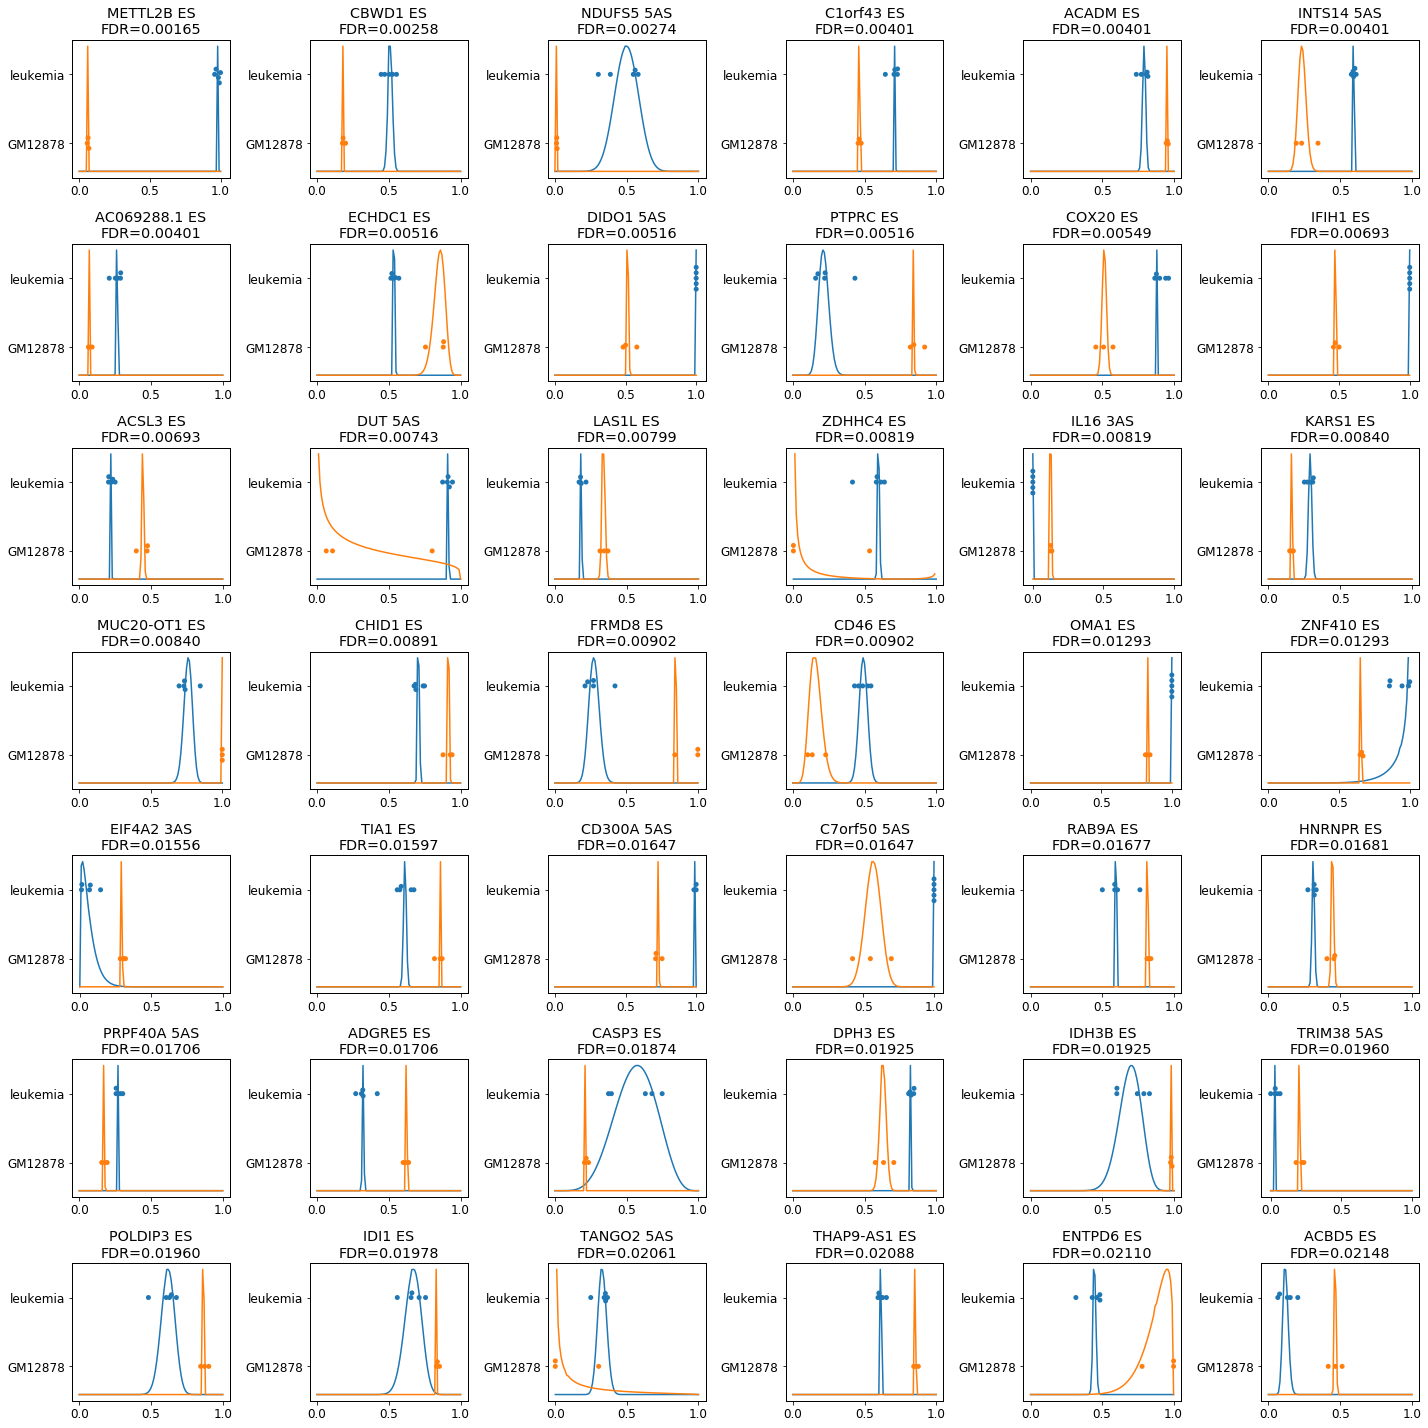

In [30]:

plt.rcParams["figure.figsize"] = (20,20)
f,axs,plotted=plot_diff_results(res[diff_cmp], min_diff=.1,grid_shape=(7,6),min_support=2, splice_types=types_of_interest)
f.savefig(f'encode_diff_betabinomial_{"_".join(groups)}.png')
plotted.to_csv(f'encode_diff_betabinomial_plot_{"_".join(groups)}.csv', index=False)

METTL2B ES (known) FDR=1.65e-03: leukemia=98.2 vs GM12878=6.2 PSI


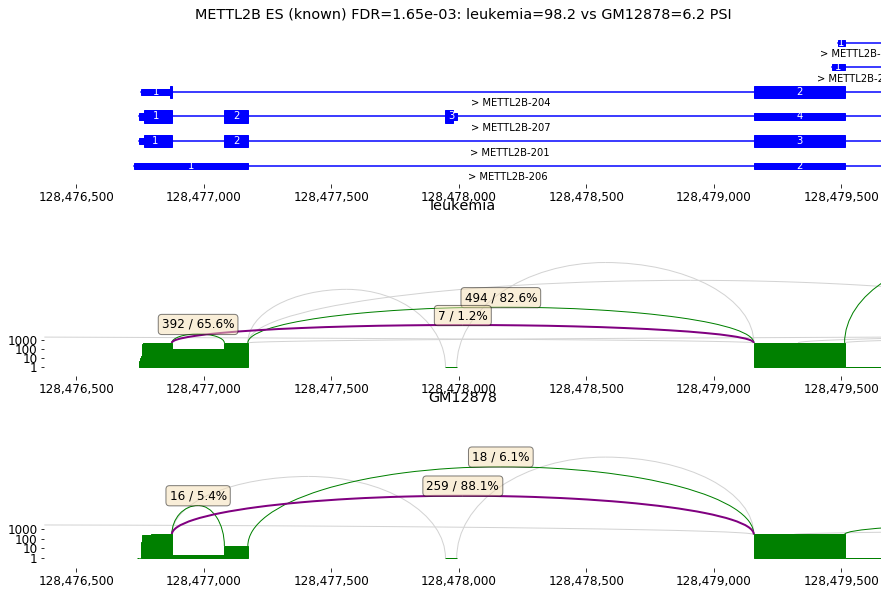

In [49]:
#sashimi plot for differential spliced genes
plt.rcParams["figure.figsize"] = (15,10)
#1) select gene of interest
row=res[diff_cmp].iloc[2]
plot_diff_example(row, isoseq, groups)

### Carcinoma cell lines
Carcinomas often feature mutations in RBM10 or deregulation of SRSF1, SRSF3 and SRSF6, each leading to specific splicing defects. 

In [32]:

diff_cmp='Panc1/progenitor cell of endocrine pancreas'
groups={k:isoseq.groups()[k] for k in diff_cmp.split('/')}


#takes about 30 min
res[diff_cmp]=isoseq.altsplice_test(groups).sort_values('pvalue').reset_index()
res[diff_cmp].to_csv(f'encode_diff_betabinomial_{"_".join(groups)}.csv', index=False)
#res[diff_cmp]=pd.read_csv(f'encode_diff_betabinomial_{"_".join(groups)}.csv')
sig=res[diff_cmp].padj<.1
print(f'{sum(sig)} differential splice sites in {len(res[diff_cmp].loc[sig,"gene"].unique())} genes for {" vs ".join(groups)}')
res[diff_cmp][res[diff_cmp].splice_type.isin(types_of_interest)].head(10)

INFO:testing differential splicing for Panc1 (1) vs progenitor cell of endocrine pancreas (2) using proportions test
  1%|          | 6421/571113 [00:00<00:08, 63707.15it/s]/home/lienhard/.local/lib/python3.7/site-packages/isotools/_transcriptome_stats.py:23: RuntimeWarning: invalid value encountered in long_scalars
  p1=[x[i]/n[i] for i in range(2)]
/home/lienhard/.local/lib/python3.7/site-packages/isotools/_transcriptome_stats.py:25: RuntimeWarning: divide by zero encountered in long_scalars
  z=abs(p1[0]-p1[1])/np.sqrt(p0*(1-p0)*(1/n[0]+1/n[1]))
100%|██████████| 571113/571113 [07:10<00:00, 1327.24it/s]


6856 differential splice sites in 3657 genes for Panc1 vs progenitor cell of endocrine pancreas


index       gene             gene_id  chrom strand      start        end  \
18    2016       PSAP  ENSG00000197746.14  chr10      -   71822007   71825836   
56    1965       ADD3  ENSG00000148700.15  chr10      +  110130486  110133325   
100  11607  HNRNPA2B1  ENSG00000122566.22   chr7      -   26190460   26192494   
119   8896      PLOD2  ENSG00000152952.12   chr3      -  146076895  146079115   
120  10771     ADGRG6  ENSG00000112414.15   chr6      +  142382019  142390257   
127   4070     HNRNPC  ENSG00000092199.18  chr14      -   21230366   21230996   
135    533       CD46  ENSG00000117335.20   chr1      +  207767195  207770320   
138    534       CD46  ENSG00000117335.20   chr1      +  207785682  207793518   
139   9628      EXOC1  ENSG00000090989.18   chr4      +   55883928   55890222   
149  13345      ACOT9  ENSG00000123130.17   chrX      -   23733217   23735918   

    splice_type  novel           padj  ...  \
18          5AS   True  2.237616e-197  ...   
56           ES  False  8.378435e-101  ...   
100         5AS   True   8.132031e-70  ...   
119          ES  False   4.501002e-64  ...   
120          ES  False   1.110302e-63  ...   
127         5AS  False   5.963530e-62  ...   
135          ES  False   3.891823e-60  ...   
138          ES  False   9.836878e-60  ...   
139          ES  False   2.271270e-59  ...   
149          ES  False   7.536668e-57  ...   

     progenitor cell of endocrine pancreas_PSI  \
18                                    0.071072   
56                                    0.992537   
100                                   0.950000   
119                                   0.192140   
120                                   0.985849   
127                                   0.223974   
135                                   0.830250   
138                                   0.076142   
139                                   0.959627   
149                                   0.000000   

     progenitor cell of endocrine pancreas_disp  total_PSI  total_disp  \
18                                            0   0.200403           0   
56                                            0   0.794872           0   
100                                           0   0.505076           0   
119                                           0   0.646134           0   
120                                           0   0.581114           0   
127                                           0   0.276768           0   
135                                           0   0.706996           0   
138                                           0   0.174750           0   
139                                           0   0.835580           0   
149                                           0   0.129371           0   

     Panc1_1_1_Panc1_in_cov  Panc1_1_1_Panc1_total_cov  \
18                     2214                       7688   
56                        4                        105   
100                       9                        194   
119                     449                        534   
120                      31                        201   
127                     308                        532   
135                      96                        296   
138                     152                        314   
139                       1                         49   
149                      37                         40   

     progenitor_cell_of_endocrine_pancreas_2_1_progenitor cell of endocrine pancreas_in_cov  \
18                                                 107                                        
56                                                 171                                        
100                                                 59                                        
119                                                 20                                        
120                                                 80                                        
127                            

PSAP 5AS (novel) FDR=2.24e-197: Panc1=28.8 vs progenitor cell of endocrine pancreas=7.1 PSI


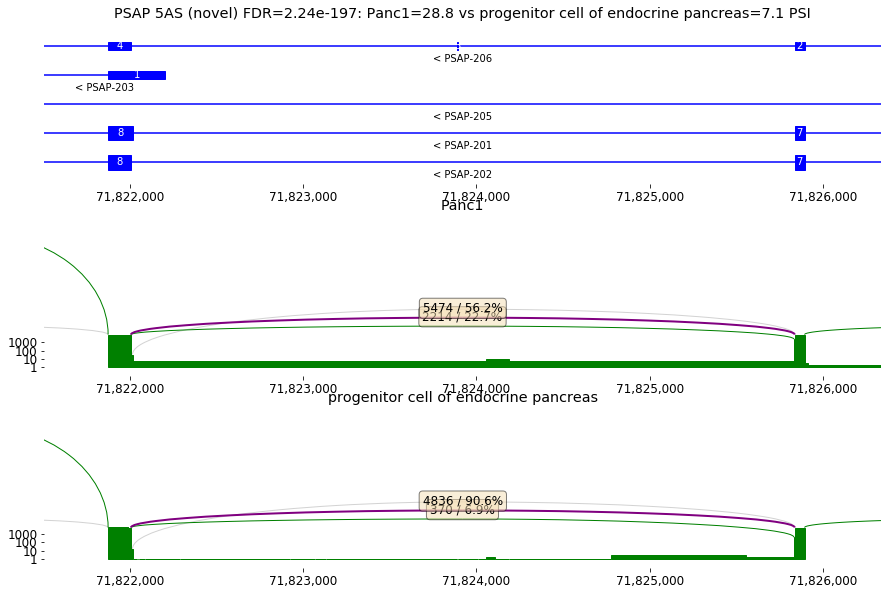

In [51]:
#sashimi plot for differential spliced genes
plt.rcParams["figure.figsize"] = (15,10)
#1) select gene of interest: PSAP this looks like a missaligned exon skipping event
row=res[diff_cmp].iloc[18]
plot_diff_example(row, isoseq, groups)

In [34]:
#all carcinoma vs normal endoderm
karyotype=isoseq.groups('karyotype')
lineage=isoseq.groups('lineage')
cell=isoseq.groups('cell')

groups={'carcinoma':[sa for sa in karyotype['cancer'] if sa in cell['epithelial cell']], 
        'normal endoderm':[sa for sa in karyotype['normal'] if sa in lineage['endoderm']]}
diff_cmp='/'.join(groups)

#takes about 30 min
res[diff_cmp]=isoseq.altsplice_test(groups).sort_values('pvalue').reset_index()
res[diff_cmp].to_csv(f'encode_diff_betabinomial_{"_".join(groups)}.csv', index=False)
#res[diff_cmp]=pd.read_csv(f'encode_diff_betabinomial_{"_".join(groups)}.csv')
sig=res[diff_cmp].padj<.1
print(f'{sum(sig)} differential splice sites in {len(res[diff_cmp].loc[sig,"gene"].unique())} genes for {" vs ".join(groups)}')
res[diff_cmp][res[diff_cmp].splice_type.isin(types_of_interest)].head(10)

INFO:testing differential splicing for carcinoma (5) vs normal endoderm (9) using betabinom_lr test
100%|██████████| 571113/571113 [17:22<00:00, 548.00it/s]  


8602 differential splice sites in 5246 genes for carcinoma vs normal endoderm


index      gene             gene_id  chrom strand      start        end  \
43   24852      NONO  ENSG00000147140.17   chrX      +   71283721   71290628   
83    9431   EEF2KMT  ENSG00000118894.15  chr16      -    5095514    5097643   
188  20225     PNISR  ENSG00000132424.16   chr6      -   99414690   99425214   
229   5575      ERC1  ENSG00000082805.20  chr12      +     991322    1027747   
315  23268  SECISBP2  ENSG00000187742.15   chr9      +   89332986   89334635   
373   7051     KHNYN  ENSG00000100441.10  chr14      +   24429991   24430713   
602   1939      POGK  ENSG00000143157.12   chr1      +  166839604  166840954   
647  18598    LARP1B  ENSG00000138709.19   chr4      +  128061401  128074459   
656   5541    SCARB1  ENSG00000073060.16  chr12      -  124778586  124786356   
667  10409    ZNF207  ENSG00000010244.19  chr17      +   32365487   32367771   

    splice_type  novel      padj  ...  IMR-90_1_1_normal endoderm_in_cov  \
43           ES  False  0.000441  ...                                224   
83          5AS  False  0.000504  ...                                  3   
188          ES  False  0.000771  ...                                 24   
229         5AS  False  0.000827  ...                                  9   
315         3AS  False  0.000940  ...                                 13   
373         5AS  False  0.001052  ...                                 15   
602         5AS  False  0.001460  ...                                  5   
647         5AS   True  0.001541  ...                                  8   
656          ES  False  0.001550  ...                                 20   
667          ES  False  0.001582  ...                                 26   

     IMR-90_1_1_normal endoderm_total_cov  \
43                                    249   
83                                     21   
188                                    25   
229                                    23   
315                                    14   
373                                    19   
602                                     9   
647                                    19   
656                                    24   
667                                    41   

     type_B_pancreatic_cell_2_1_normal endoderm_in_cov  \
43                                                1341   
83                                                   2   
188                                                214   
229                                                  4   
315                                                 25   
373                                                  0   
602                                                  0   
647                                                  0   
656                                                  0   
667                                                364   

     type_B_pancreatic_cell_2_1_normal endoderm_total_cov  \
43                                                1428      
83                                                  24      
188                                                249      
229                                                 18      
315                                                 38      
373                                                  0      
602                                                 27      
647                                                 15      
656                                                  0      
667                                                425      

     type_B_pancreatic_cell_1_1_normal endoderm_in_cov  \
43                                                 697   
83                                                   0   
188                                                191   
229                                                  5   
315                                                 48   
373                                                  0   
602                                                  0   
647             

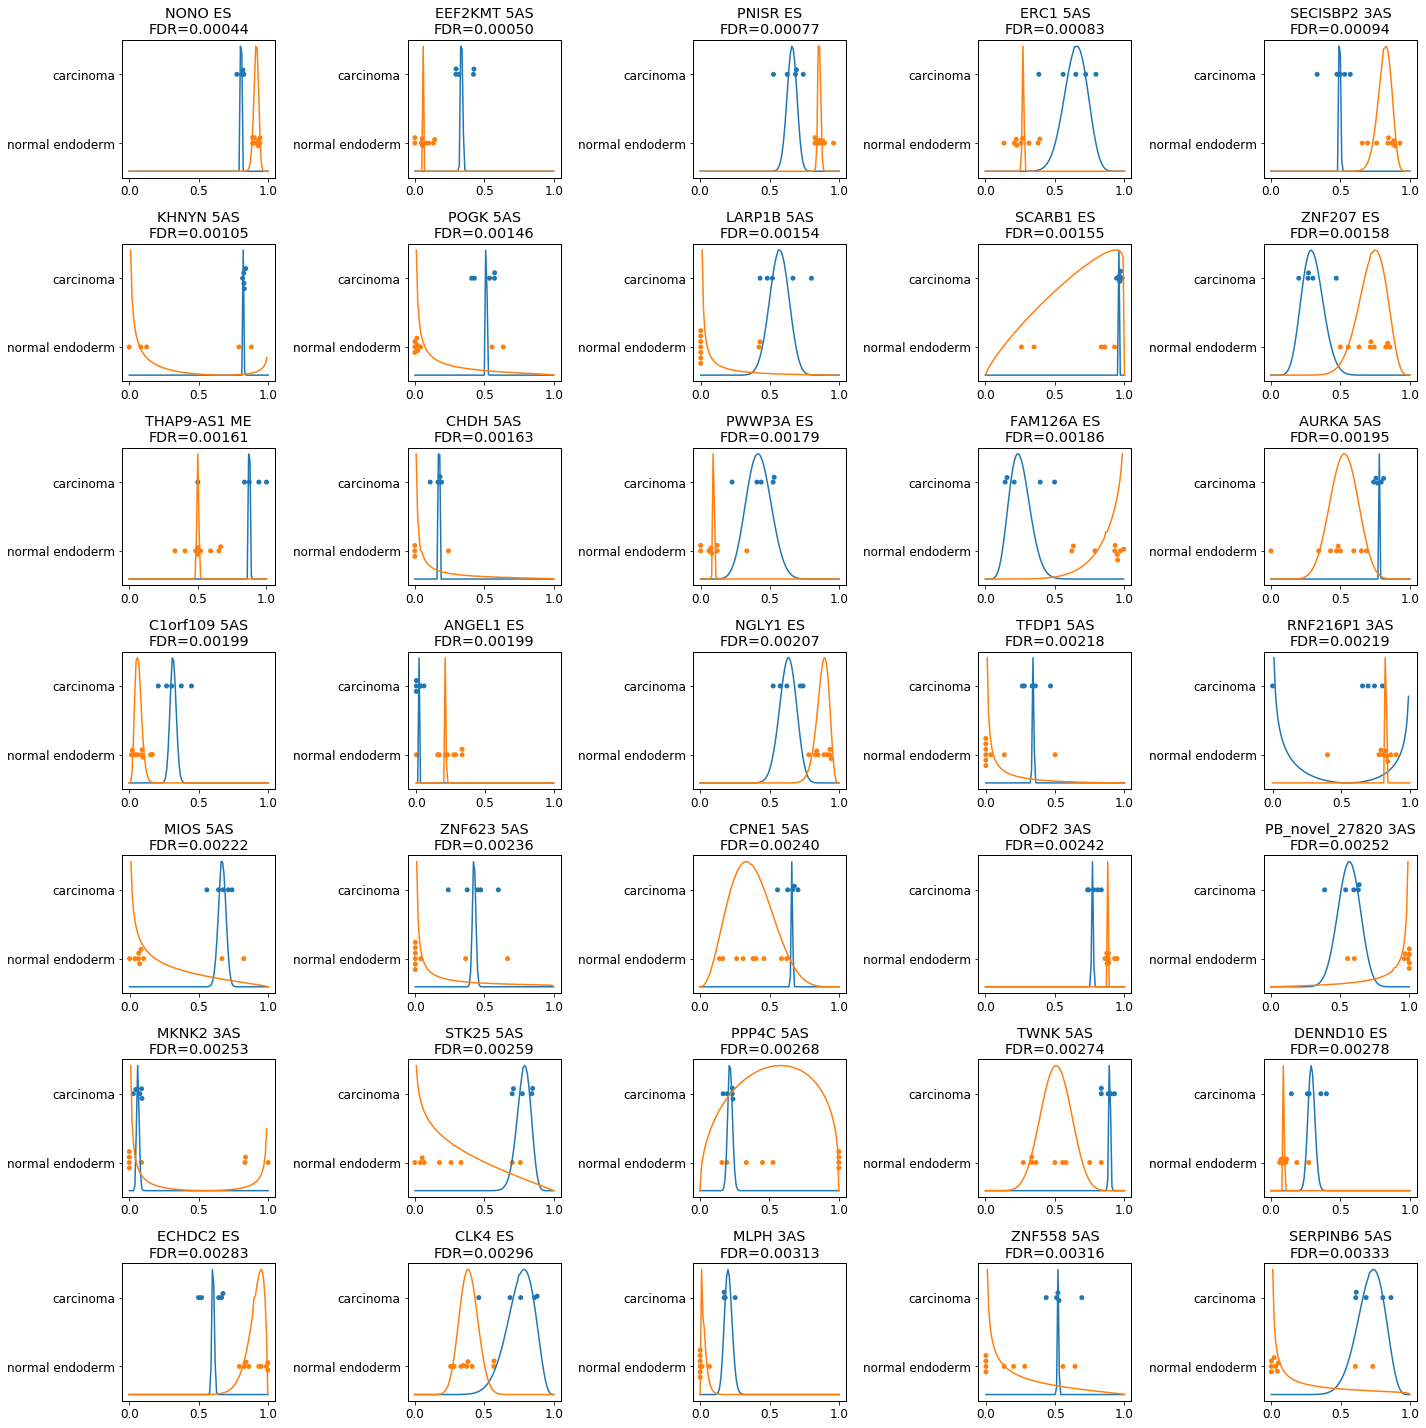

In [35]:

plt.rcParams["figure.figsize"] = (20,20)
f,axs,plotted=plot_diff_results(res[diff_cmp], min_diff=.1,grid_shape=(7,5),min_support=2, splice_types=['ES', 'ME', '5AS', '3AS'])
f.savefig(f'encode_diff_betabinomial_{"_".join(groups)}.png')
plotted.to_csv(f'encode_diff_betabinomial_plot_{"_".join(groups)}.csv', index=False)

SMUG1 PAS (novel) FDR=2.31e-04: carcinoma=53.6 vs normal endoderm=89.3 PSI


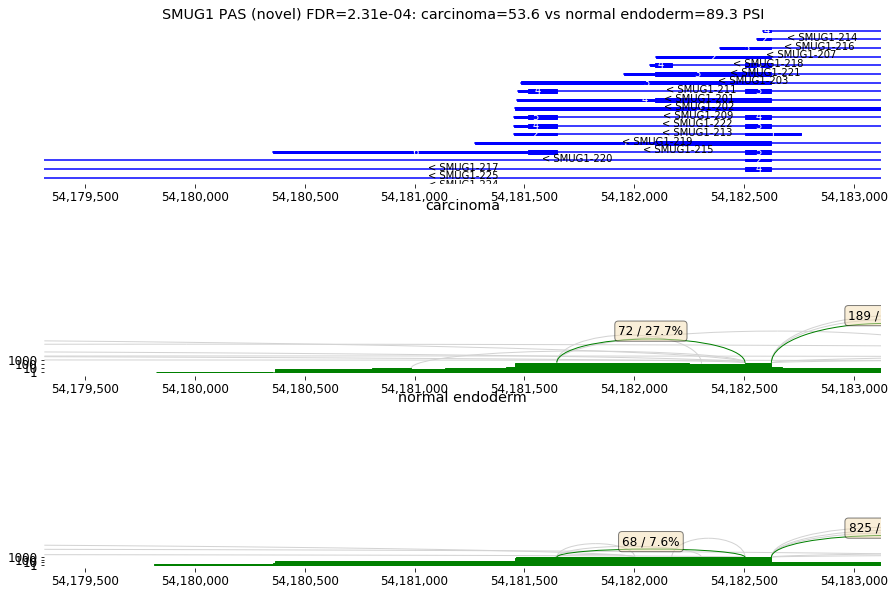

In [36]:
#sashimi plot for differential spliced genes
plt.rcParams["figure.figsize"] = (15,10)
#1) select gene of interest
row=res[diff_cmp].iloc[1]
plot_diff_example(row, isoseq, groups)

In [37]:
#differential splicing all leukemia vs carcinoma

gr=isoseq.groups()
groups={'leukemia':gr['K562']+gr['HL-60'], 'carcinoma':gr['Panc1']+gr['HCT116']+gr['HepG2']+gr['PC-3']+gr['MCF-7']}
diff_cmp='/'.join(groups)

#takes about 30 min
res[diff_cmp]=isoseq.altsplice_test(groups).sort_values('pvalue').reset_index()
res[diff_cmp].to_csv(f'encode_diff_betabinomial_{"_".join(groups)}.csv', index=False)
#res[diff_cmp]=pd.read_csv(f'encode_diff_betabinomial_{"_".join(groups)}.csv')
sig=res[diff_cmp].padj<.1
print(f'{sum(sig)} differential splice sites in {len(res[diff_cmp].loc[sig,"gene"].unique())} genes for {" vs ".join(groups)}')
res[diff_cmp][res[diff_cmp].splice_type.isin(types_of_interest)].head(10)

INFO:testing differential splicing for leukemia (5) vs carcinoma (5) using betabinom_lr test
100%|██████████| 571113/571113 [17:38<00:00, 539.61it/s] 


4474 differential splice sites in 3107 genes for leukemia vs carcinoma


index     gene             gene_id  chrom strand      start        end  \
7    3986   PICALM  ENSG00000073921.18  chr11      -   85976682   85981128   
8   22981   ECHDC1  ENSG00000093144.19   chr6      -  127314896  127327001   
13   7541     AKT1  ENSG00000142208.17  chr14      -  104792722  104795483   
16  21220     GRK6  ENSG00000198055.11   chr5      +  177441053  177441736   
26  26432    CBWD1  ENSG00000172785.18   chr9      -     175784     178815   
29  16512  MARCHF7  ENSG00000136536.15   chr2      +  159762993  159767283   
32  24500     EZH2  ENSG00000106462.11   chr7      -  148832750  148846496   
35  16201    HSPD1  ENSG00000144381.18   chr2      -  197494250  197495293   
49  13619     PLD3  ENSG00000105223.20  chr19      +   40348768   40366418   
56   2943    P4HA1  ENSG00000122884.12  chr10      -   73030370   73046924   

   splice_type  novel      padj  ...  Panc1_1_1_carcinoma_in_cov  \
7           ES  False  0.004027  ...                          80   
8           ES  False  0.004329  ...                          83   
13          ES  False  0.004329  ...                         114   
16         3AS  False  0.004329  ...                          30   
26          ES  False  0.004369  ...                           1   
29          ES  False  0.004369  ...                         177   
32         5AS  False  0.004629  ...                          38   
35         5AS  False  0.004713  ...                          21   
49          ES  False  0.005233  ...                          31   
56          ME  False  0.005337  ...                          91   

    Panc1_1_1_carcinoma_total_cov  HCT116_1_1_carcinoma_in_cov  \
7                             105                           50   
8                             101                           56   
13                            930                          189   
16                            115                           32   
26                             22                           22   
29                            284                          244   
32                             43                           44   
35                             25                           14   
49                             43                           30   
56                            196                           88   

    HCT116_1_1_carcinoma_total_cov  HepG2_1_1_carcinoma_in_cov  \
7                               61                          72   
8                               70                         101   
13                             815                         129   
16                             187                          57   
26                             156                          24   
29                             262                         369   
32                              51                          22   
35                              15                          76   
49                              57                          49   
56                             138                         170   

    HepG2_1_1_carcinoma_total_cov  PC-3_1_1_carcinoma_in_cov  \
7                             118                         41   
8                             133                         36   
13                           1253                         81   
16                            149                         20   
26                            186                         32   
29                            538                        211   
32                             24                         10   
35                             98                         16   
49                             83                         73   
56                            357                        450   

    PC-3_1_1_carcinoma_total_cov  MCF-7_1_1_carcinoma_in_cov  \
7                             47                          65   
8                             45                          32   
13                           744             

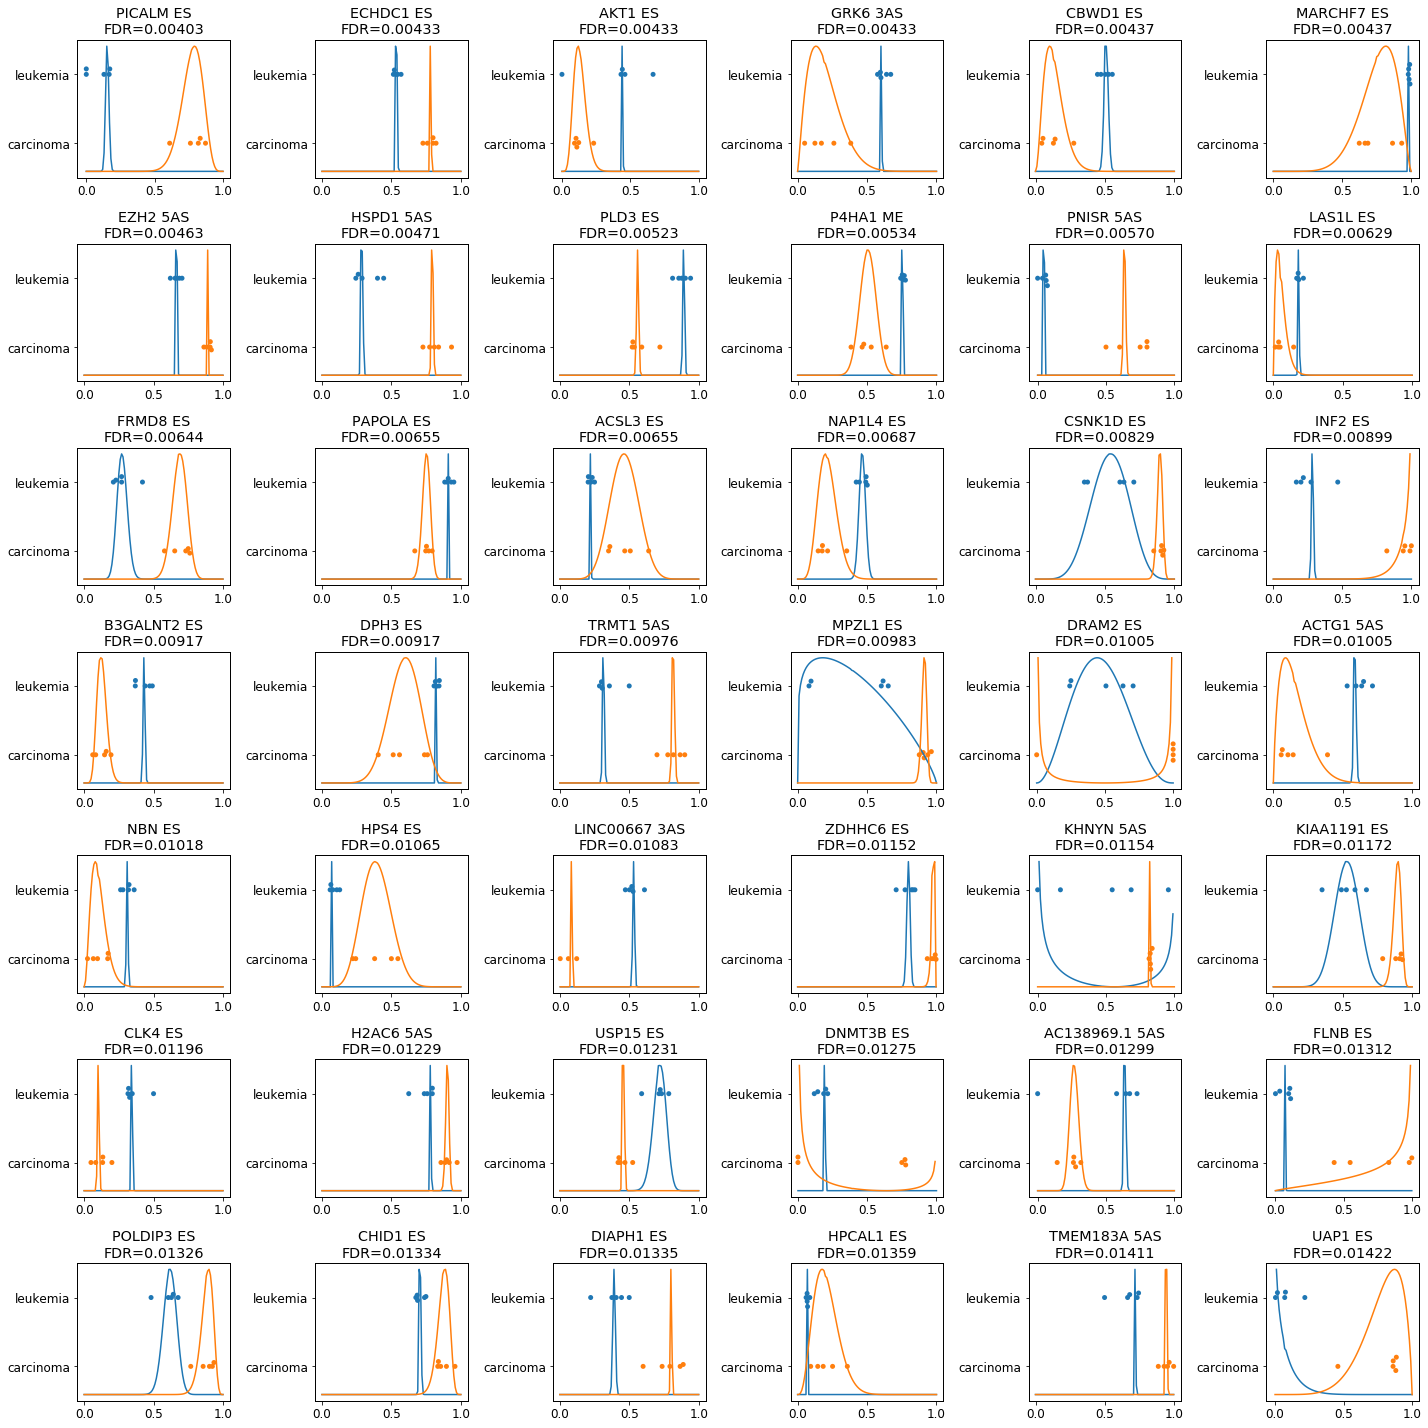

In [38]:

plt.rcParams["figure.figsize"] = (20,20)
f,axs,plotted=plot_diff_results(res[diff_cmp], min_diff=.1,grid_shape=(7,6),min_support=3, splice_types=['ES', 'ME', '5AS', '3AS'])
f.savefig(f'encode_diff_betabinomial_{"_".join(groups)}.png')
plotted.to_csv(f'encode_diff_betabinomial_plot_{"_".join(groups)}.csv', index=False)

PICALM ES (known) FDR=4.03e-03: leukemia=15.4 vs carcinoma=77.2 PSI


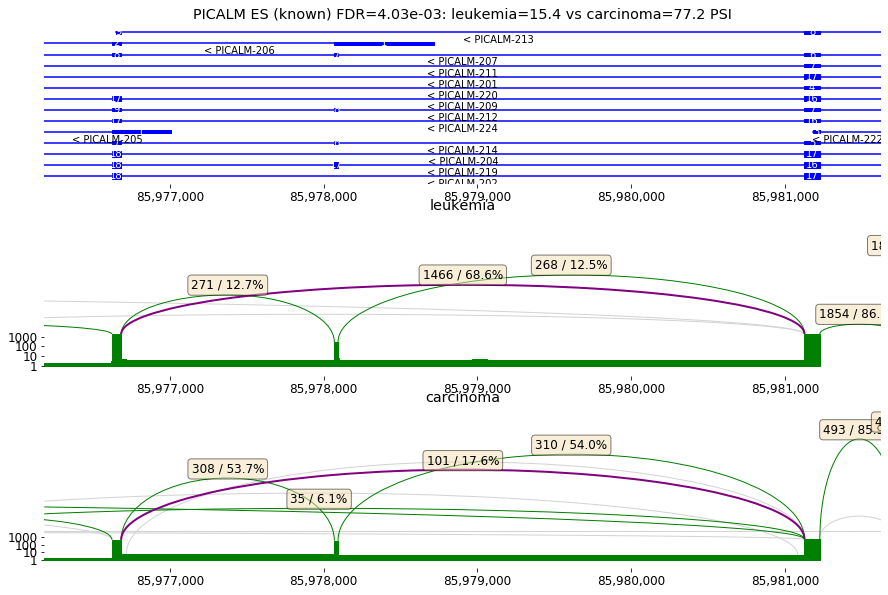

In [53]:
#sashimi plot for differential spliced genes
plt.rcParams["figure.figsize"] = (15,10)
#1) select gene of interest
row=res[diff_cmp].iloc[7]
plot_diff_example(row, isoseq, groups)